# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 60
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample File and Declaring XGA ClusterSample

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 45/45 [02:57<00:00,  3.94s/it]
/tmp/ipykernel_7365/3362635027.py:11: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); ZwCl0949.6+5207, Abell1423, RXCJ1212.3-1816, Abell1682, Abell2485
  locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:224: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


In [ ]:
from xga.exceptions import NoProductAvailableError

which = []
for src in locuss_srcs:
    try:
        mp = src.get_hydrostatic_mass_profiles()
        which.append(mp.src_name)
    except NoProductAvailableError:
        pass
len(which)

In [ ]:
locuss[np.isfinite(locuss['x_m500']) & locuss['name'].isin(which)]

## Running PSF Correction

In [ ]:
rl_psf(locuss_srcs)

## Reading in literature data

### Gas masses from literature

In [4]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [5]:
loc_conv_txs = []
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to $R_{500}$

In [6]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [ ]:
loc_beta_1r500_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500, 
                                          conv_temp=loc_conv_txs)

In [ ]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

In [ ]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_1r500_dp)) as onwards:
    for dp in loc_beta_1r500_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

In [ ]:
loc_beta_king_1r500_gm500 = []
loc_beta_king_1r500_gm2500 = []

with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_1r500_dp)) as onwards:
    for dp in loc_beta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_1r500_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_1r500_gm2500.append(gm)
        else:
            loc_beta_king_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)               
        
loc_beta_king_1r500_gm500 = Quantity(loc_beta_king_1r500_gm500, 'Msun')
loc_beta_king_1r500_gm2500 = Quantity(loc_beta_king_1r500_gm2500, 'Msun')

In [ ]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_1r500_gm2500, loc_beta_king_1r500_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [7]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
loc_dblbeta_1r500_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                          conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:26<19:06, 26.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1203.62760315  978.28234948 1163.89955912 1216.08810679 1190.3111437
 1083.71672003]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/45 [00:53<19:19, 26.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [441.75394021 527.12162386 408.71957587 409.04025517 404.6957395
 445.53752817]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:18<18:04, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1808.54996628 1134.77250559 2261.80205275 1607.34166551 1872.5329589
 2208.6464289 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0115S's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:40<16:43, 24.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 895.55195996 2045.00868677 2080.71925143 1973.23248615 2074.90233118
 2291.96614568]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/45 [02:30<16:03, 24.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 767.80591674  650.38753529 1147.43338129  929.96540586 1227.65340139
 1150.87524357]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏      | 7/45 [02:55<15:44, 24.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [204.29763097 522.28275414 619.08703401 672.54035315 723.48992694
 730.97058164]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▍      | 8/45 [03:20<15:24, 25.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 226.45503753  298.42559507 2021.76785724 1942.53839979 2006.6576237
 1957.48407934]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▌      | 9/45 [03:48<15:33, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [483.03358461 466.18952791 369.06469035 312.3981965  358.58664454
 432.94145582]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█▊     | 12/45 [05:09<14:42, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1029.13060059 1032.39219786 1096.79257803 1097.79483148 1127.74113081
 1107.9979983 ]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:34<13:53, 26.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1609.50920058  536.15079074 1747.9369534  1642.3106296  1831.77956966
 1725.09492728]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 14/45 [06:00<13:33, 26.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1683.26953767  898.12165866 1652.12843894 1518.92437767 1637.56692264
 1621.71260883]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/45 [06:26<13:03, 26.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [862.54263748 875.44476264 749.14140327 851.81133966 890.2768869
 897.32697747]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [06:52<12:37, 26.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 932.74520708 1125.87120083 1640.36809325 1170.02450815 1497.03878245
 1677.73610761]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 17/45 [07:18<12:09, 26.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 868.91778333  621.38431267 2017.78273266 1714.12710208 1781.80087735
 1875.02599934]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 18/45 [07:42<11:23, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 557.97823708  894.67067964 2150.7244096  2507.4062738  2485.82972885
 2099.69715425]


Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 21/45 [09:07<10:56, 27.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [405.03400062 402.69869919 352.46757161 384.67726979 380.64282987
 376.38054341]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 23/45 [10:01<09:54, 27.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 771.40662519  329.43925335 2064.61241122 1624.18018804 1335.71588452
 1995.989382  ]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 24/45 [10:25<09:08, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 701.81855853  747.35939122 1980.44675726  957.83182296 1253.029193
 1951.12798701]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:17<08:11, 25.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1606.78617913  318.94083224 2091.07842142  669.69266286  823.59104566
 2090.72555596]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 27/45 [11:43<07:48, 26.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 716.18561837  807.78702834 1582.26688906 1361.48732442 1193.14878535
 1212.3411781 ]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 30/45 [13:05<06:43, 26.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [621.34905946 624.56255297 574.47323362 486.55245794 526.00125667
 569.43672094]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [13:58<05:43, 26.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 667.13820539  997.71594156 1439.28487233 1515.32697562 1419.9891727
 1460.01012208]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 34/45 [14:50<04:46, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1328.35872623 1100.51677799 1366.39071052 1379.13057522 1412.16868567
 1372.54332895]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:18<04:27, 26.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1375.59241128  664.78608672 2122.95378857 2077.15397006 1796.99643198
 2121.15809136]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [18:29<01:20, 26.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1310.33139483  840.64484088 1309.75076128 1115.4997188  1207.26693483
 1333.1642466 ]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [19:19<00:25, 25.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1004.16006677 1130.34963791 2018.32687149 1616.88293757 1701.82720452
 2003.57500905]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [19:43<00:00, 26.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 321.29130223  340.01443543 1175.04011827  938.39229992  489.70946163
 1100.760037  ]


In [9]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:  16%|████▉                           | 7/45 [04:18<23:01, 36.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 741.51266512 1004.97465967 1082.10141121  547.06443253  740.57688059
 1080.99895278]


Fitting density model to LoCuSS profiles:  22%|██████▉                        | 10/45 [06:35<24:31, 42.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 89.85542636  87.49043509 657.92539553  83.59244678  83.19537871
  85.69874556]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [07:17<23:43, 41.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1988.69827639 2257.94766052 1592.70351638 1556.93843925 1915.07417363
 1639.53027672]


Fitting density model to LoCuSS profiles:  31%|█████████▋                     | 14/45 [09:23<21:46, 42.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  97.57513368   99.45804631 1126.41147809  105.74299396  105.3144773
  111.68090595]


Fitting density model to LoCuSS profiles:  33%|██████████▎                    | 15/45 [10:04<20:50, 41.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [100.29033008 116.89856266 901.24281336 105.17964938 106.34593996
 144.66213758]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [10:50<20:46, 42.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 691.85525395  783.44818185 1289.54220178  599.56332821  583.56602272
 1075.17147589]


Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [12:16<14:21, 33.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 85.19500537  82.93945528 804.07796945  85.08670403  85.57796792
  80.04310459]


Fitting density model to LoCuSS profiles:  51%|███████████████▊               | 23/45 [15:10<14:46, 40.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 102.7535064   108.33601518 1277.45942407  102.27114286  124.89821221
  172.08592515]


Fitting density model to LoCuSS profiles:  53%|████████████████▌              | 24/45 [15:52<14:17, 40.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [794.117886   777.86536031 254.55819548 603.34969861 747.96269129
 379.59035153]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [17:22<13:29, 42.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1620.27086588 1637.96384335  467.50849771 1300.76290865 1449.93695064
  791.02689504]


Fitting density model to LoCuSS profiles:  64%|███████████████████▉           | 29/45 [19:33<11:28, 43.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 482.11499389 1765.27968954 2054.22287365  242.21230749  254.55800872
  287.30610066]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [20:13<10:34, 42.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 102.27981252  102.74562528 1161.91879743  106.33273087  115.75854887
  100.50674207]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [21:44<09:25, 43.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1763.76441911 1813.99627361 2058.96285476 1050.97097548 1773.2762324
 1483.38206097]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [22:31<08:55, 44.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 55.90301906  74.86544928 733.17898486  84.92021207  87.19683037
  35.64767428]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▍       | 34/45 [23:16<08:12, 44.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [455.35393555 779.05101829 886.6217549  275.0579529  178.6567913
 822.78829535]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [31:36<00:00, 42.14s/it]


In [11]:
loc_dblbeta_svikh_1r500_gm500 = []
loc_dblbeta_svikh_1r500_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_1r500_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_1r500_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_1r500_gm500 = Quantity(loc_dblbeta_svikh_1r500_gm500, 'Msun')
loc_dblbeta_svikh_1r500_gm2500 = Quantity(loc_dblbeta_svikh_1r500_gm2500, 'Msun')

Calculating LoCuSS gas masses:   0%|                                                   | 0/45 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:512: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:04<00:00,  9.44s/it]


In [12]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_1r500_gm2500[:, 0]).sum(), 
                      t=len(loc_dblbeta_svikh_1r500_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_1r500_gm500[:, 0]).sum(), 
                      t=len(loc_dblbeta_svikh_1r500_gm500)))

43 out of 45 R2500 gas mass measurements produced a result
43 out of 45 R500 gas mass measurements produced a result


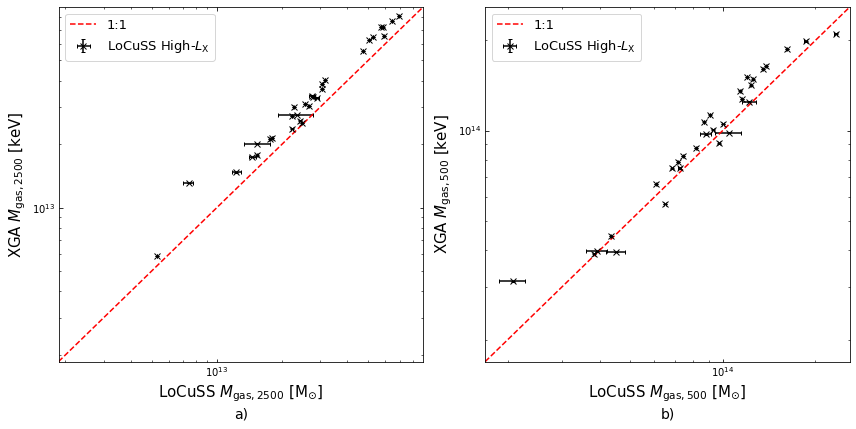

In [13]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_1r500_gm2500, 
                                                        loc_dblbeta_svikh_1r500_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_1r500_gmcomp_dblbeta_svikh.pdf')

In [15]:
loc_dblbeta_svikh_1r500_gm2500 / loc_lit_gm2500s

/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity [[1.23582828, 0.07232825, 0.07286732],
           [1.27235075, 0.60012046, 0.59138746],
           [1.14670135, 0.12892039, 0.12514405],
           [       nan,        nan,        nan],
           [       nan,        nan,        nan],
           [       nan,        nan,        nan],
           [1.32338743, 0.48787663, 0.50700595],
           [       nan,        nan,        nan],
           [1.19509897, 0.04386829, 0.04517054],
           [1.21362082, 0.28119765, 0.27347963],
           [1.11506314,        inf,        inf],
           [       nan,        nan,        nan],
           [       nan,        nan,        nan],
           [       nan,        nan,        nan],
           [1.15105842, 0.59756937, 0.59203932],
           [       nan,        nan,        nan],
           [1.25996028, 0.6851391 , 0.66469569],
           [       nan,        nan,        nan],
           [1.77154904, 0.04087713, 0.04005053],
           [1.02211662, 0.26717315, 0.2628205 ],
           [1.203641

In [20]:
np.nanmean((loc_dblbeta_svikh_1r500_gm500 / loc_lit_gms)[:, 0])

<Quantity 1.09407235>

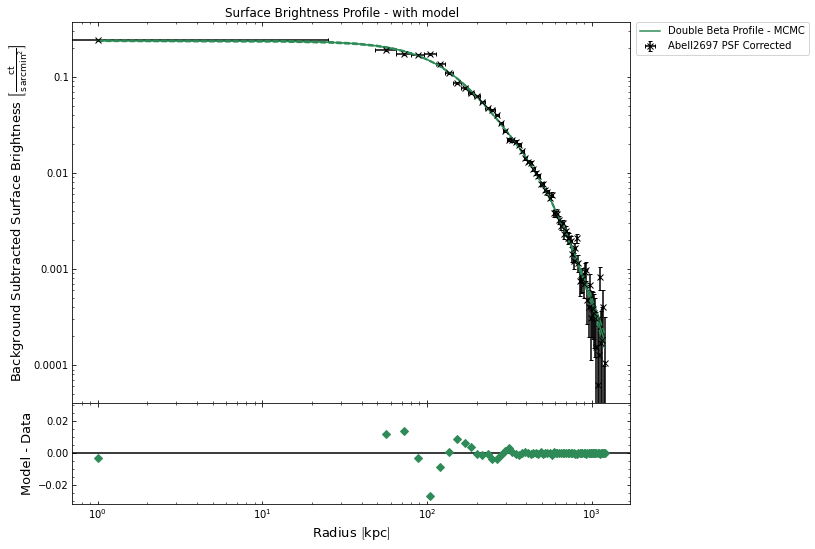

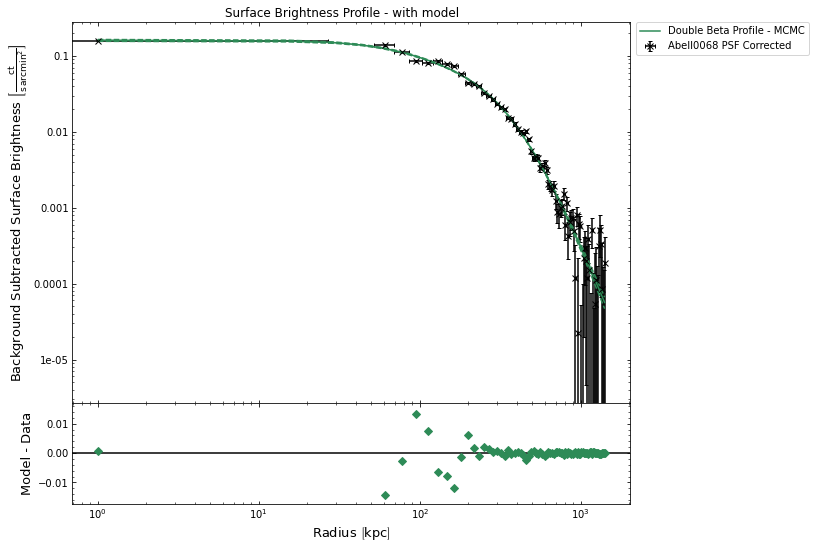

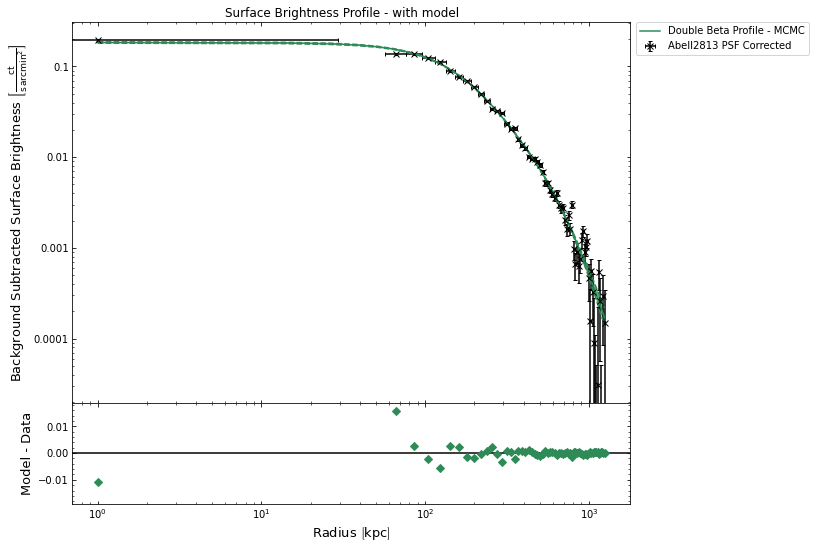

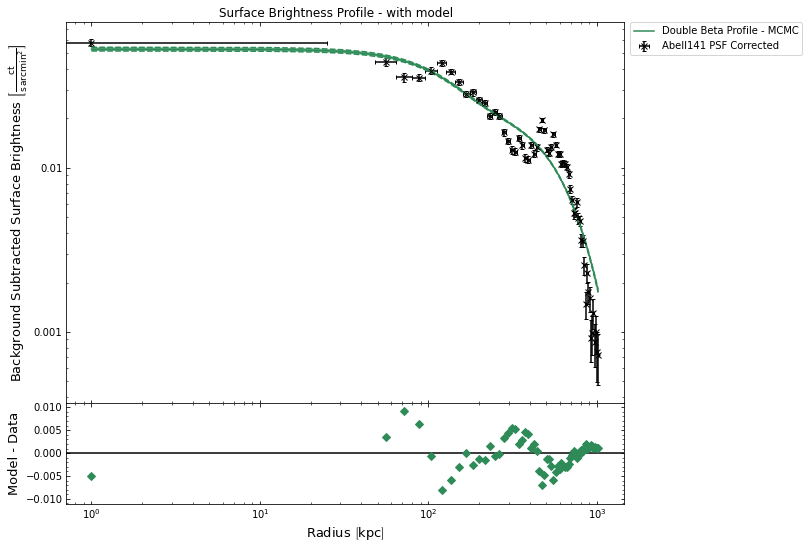

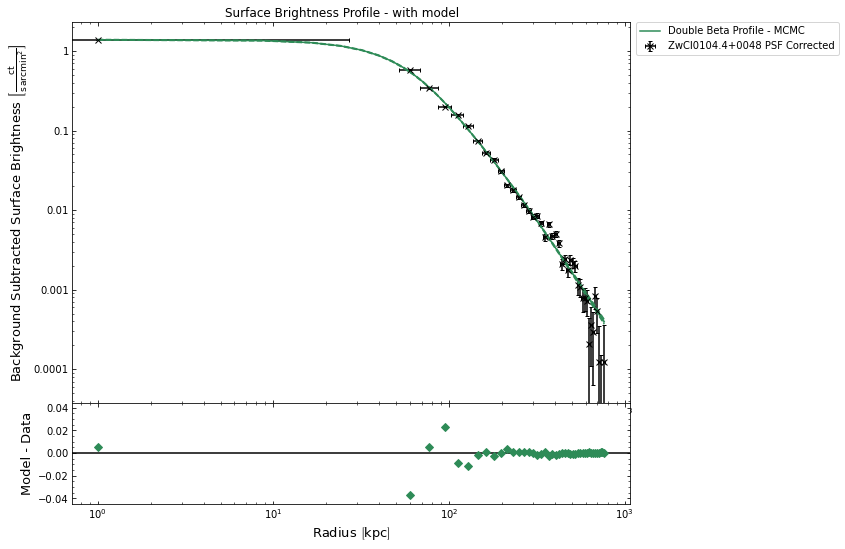

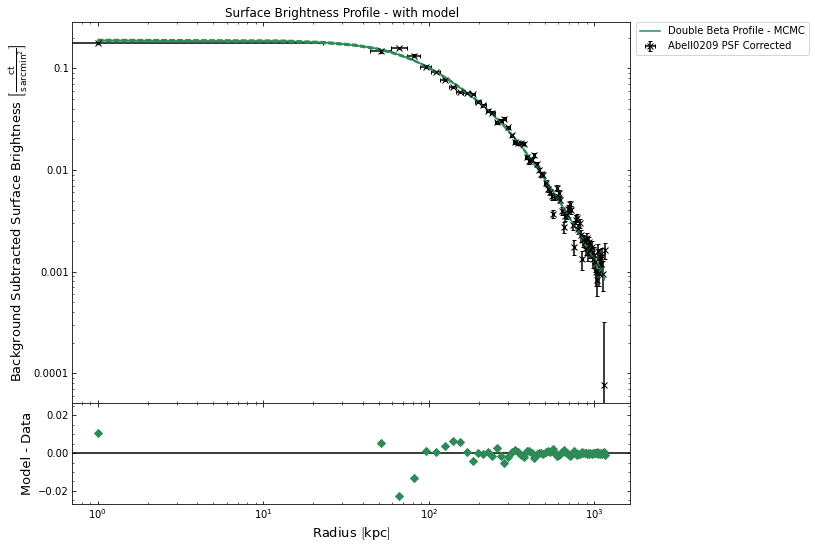

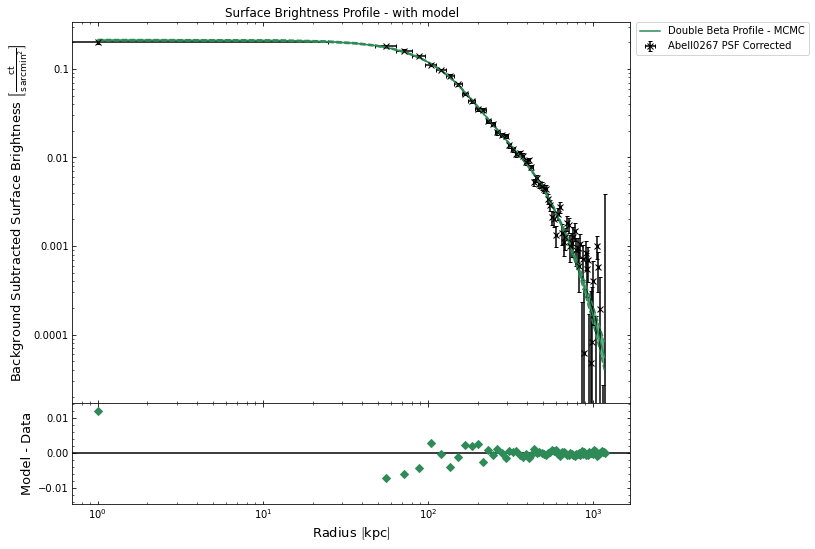

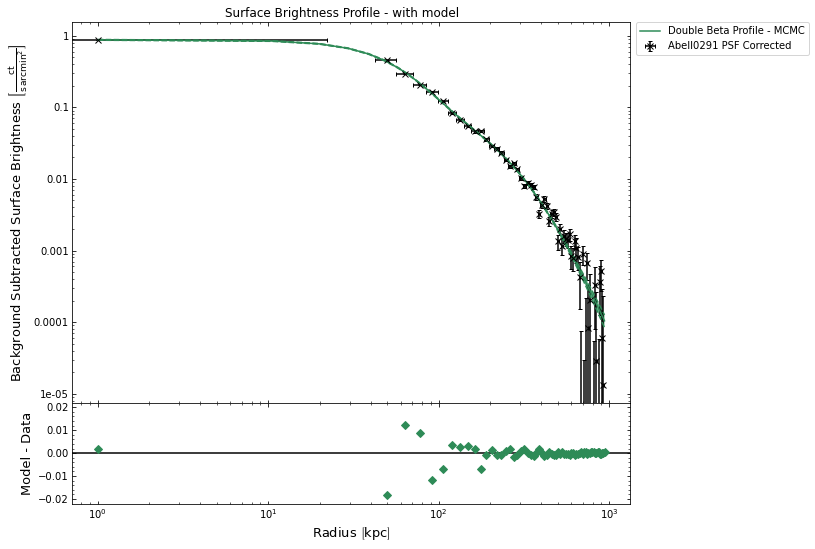

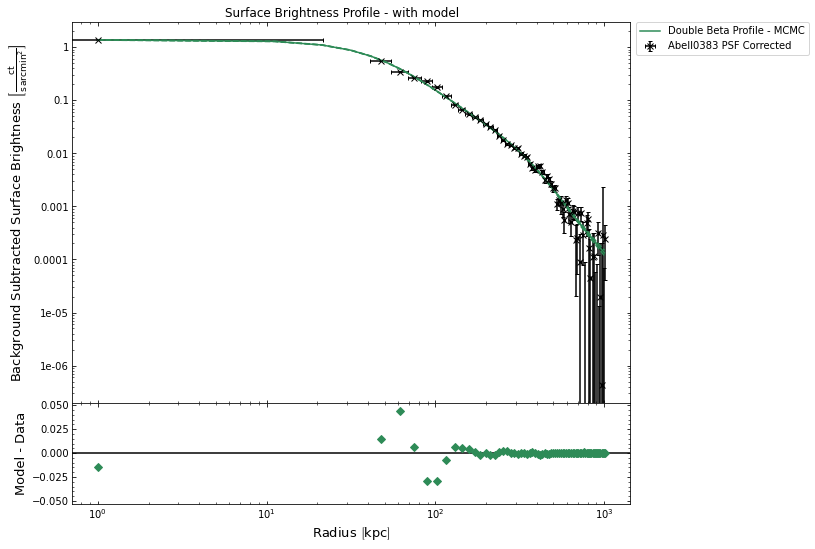

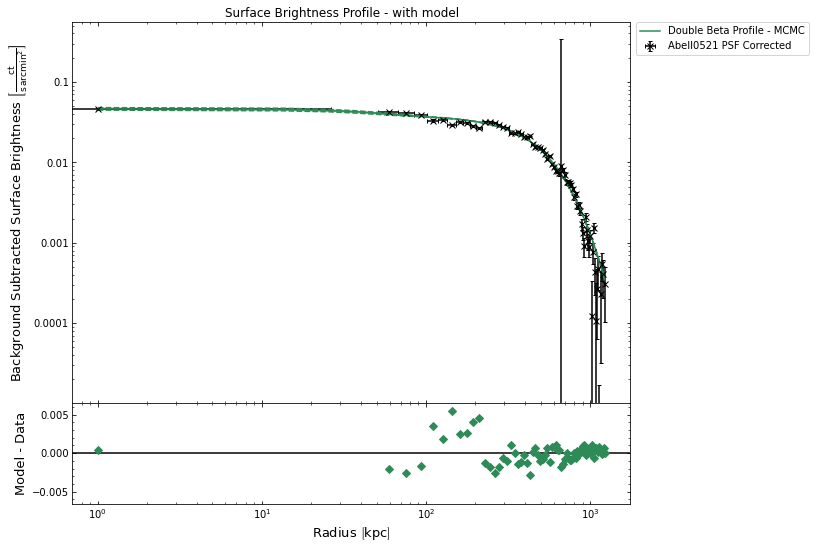

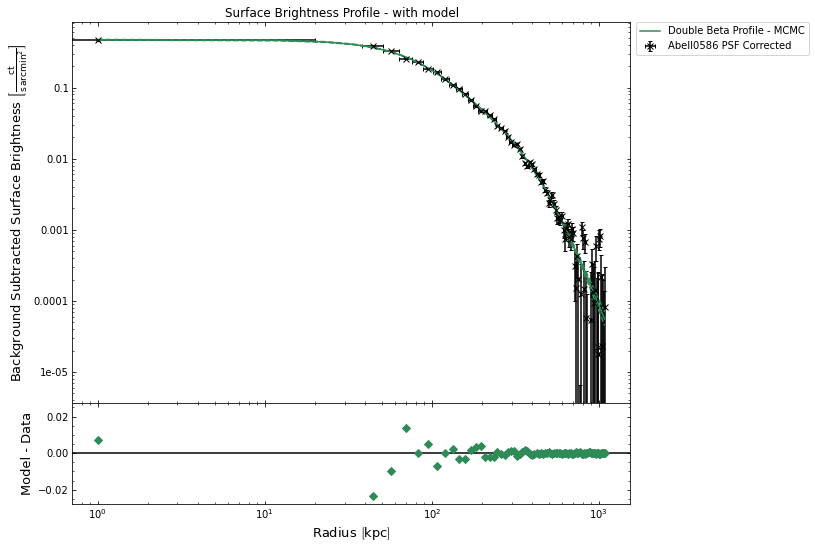

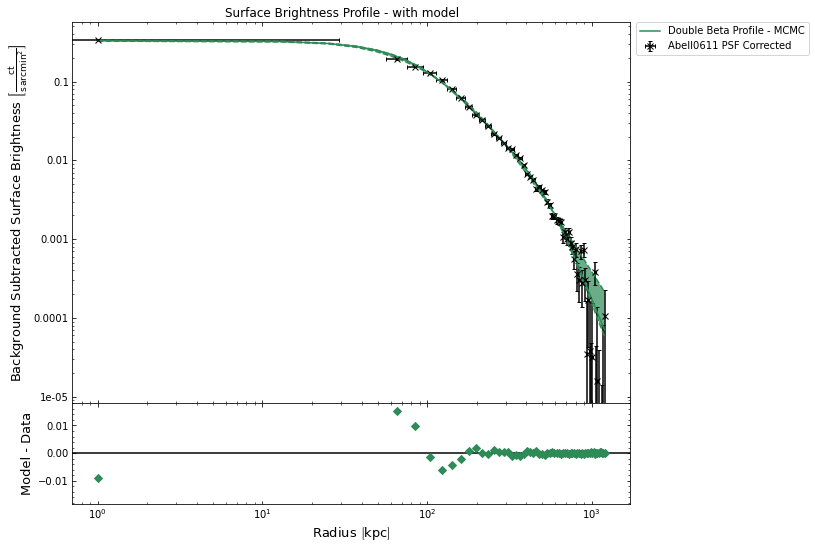

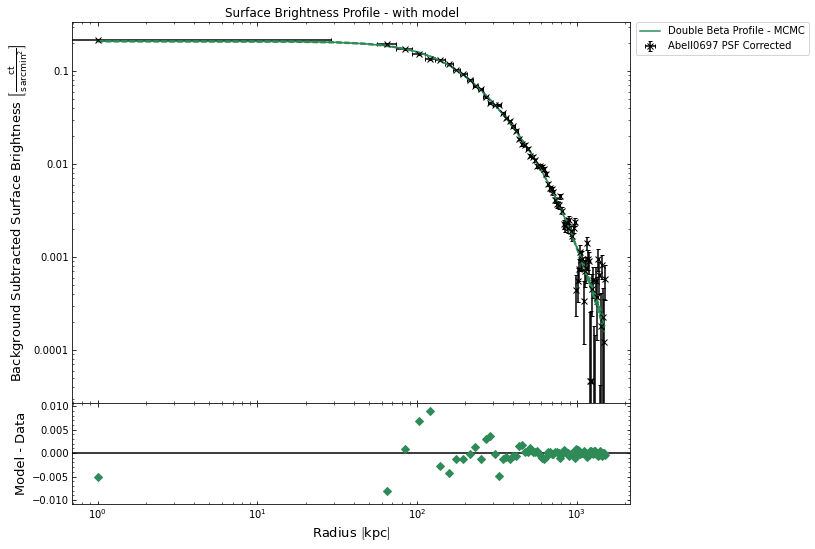

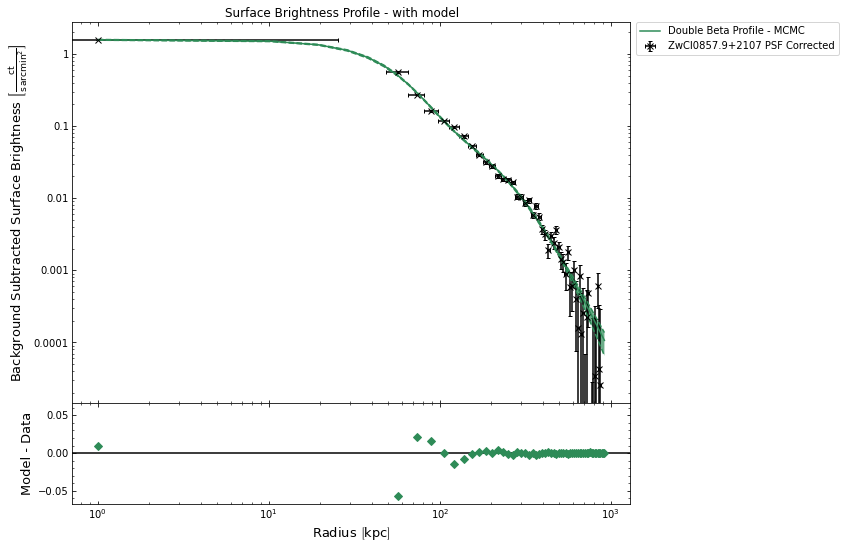

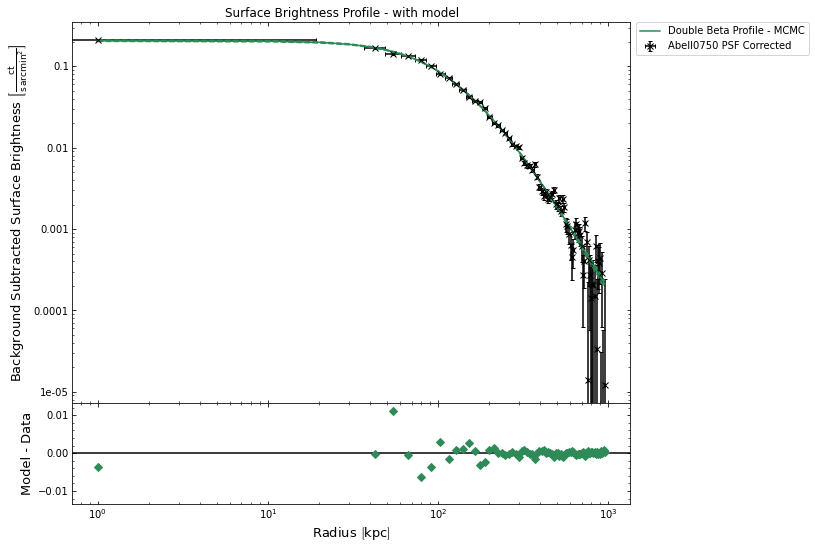

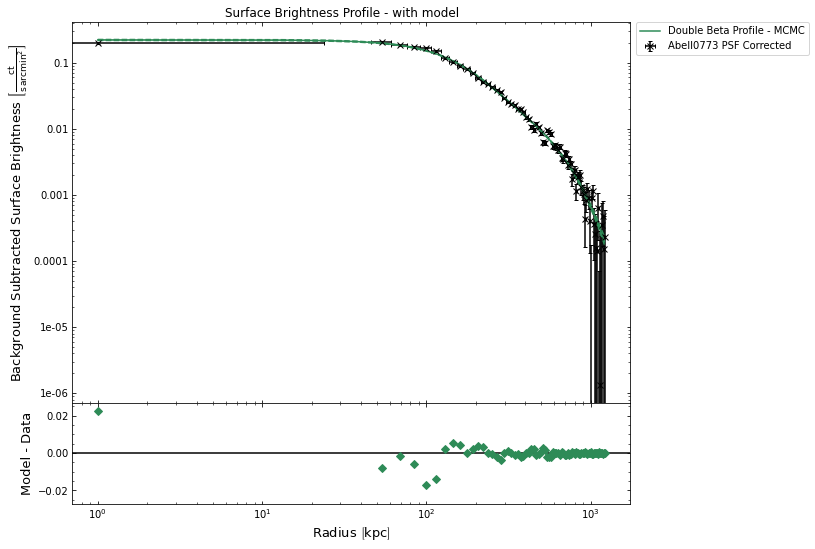

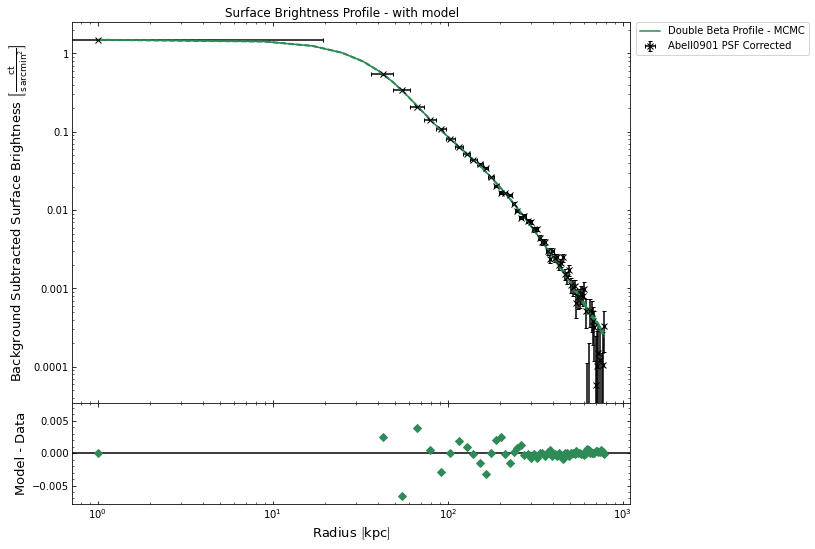

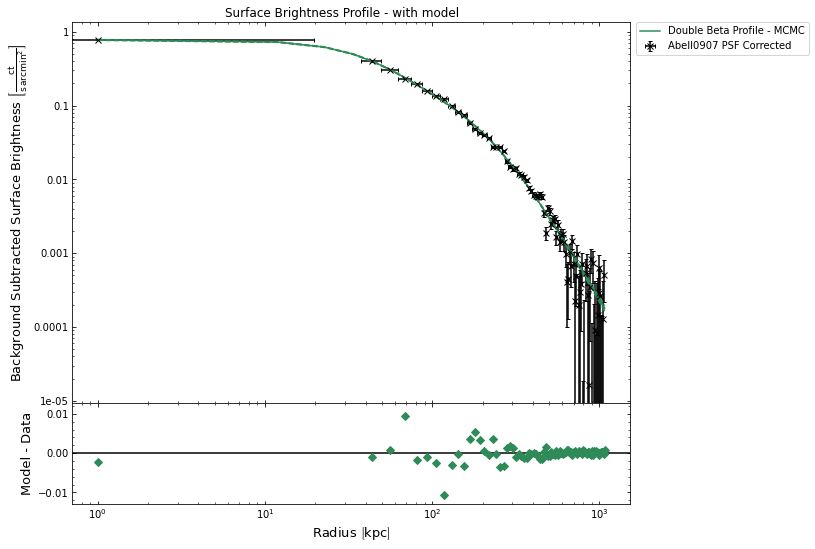

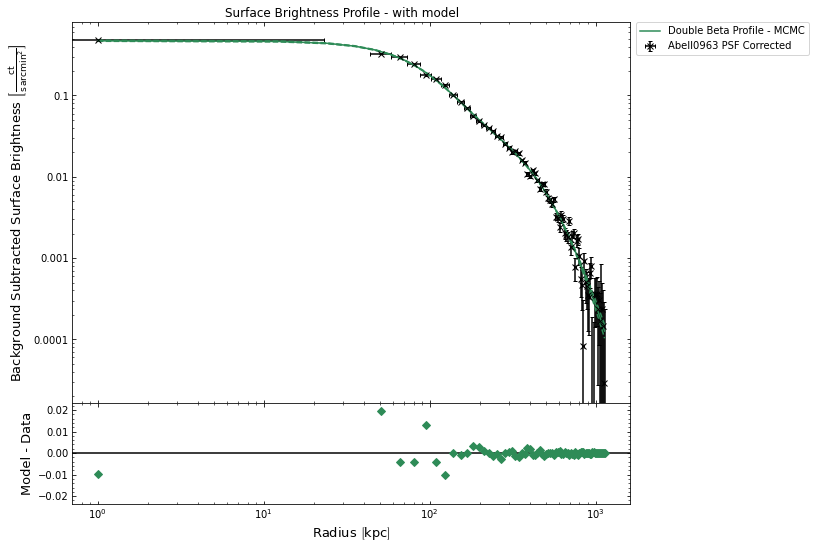

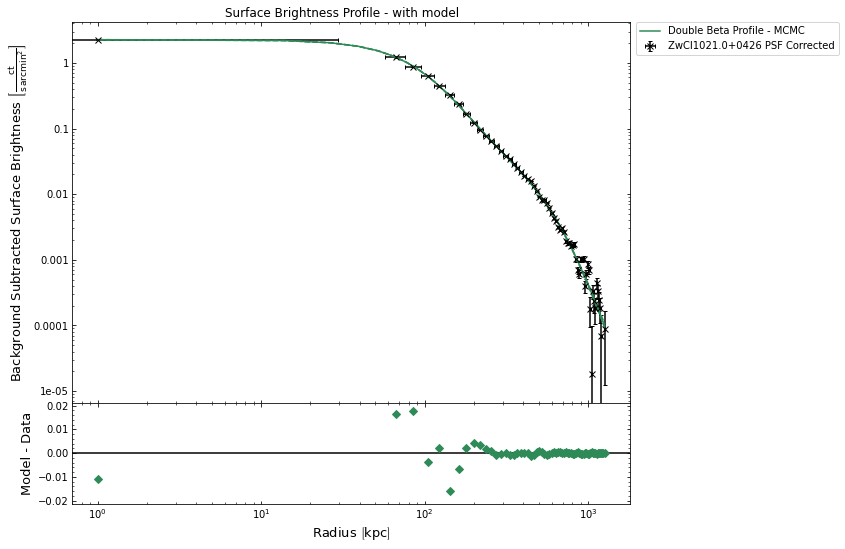

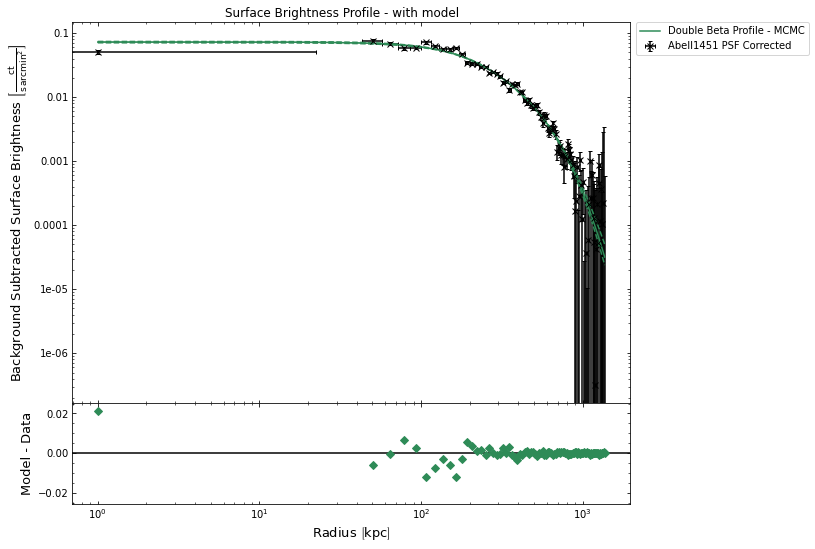

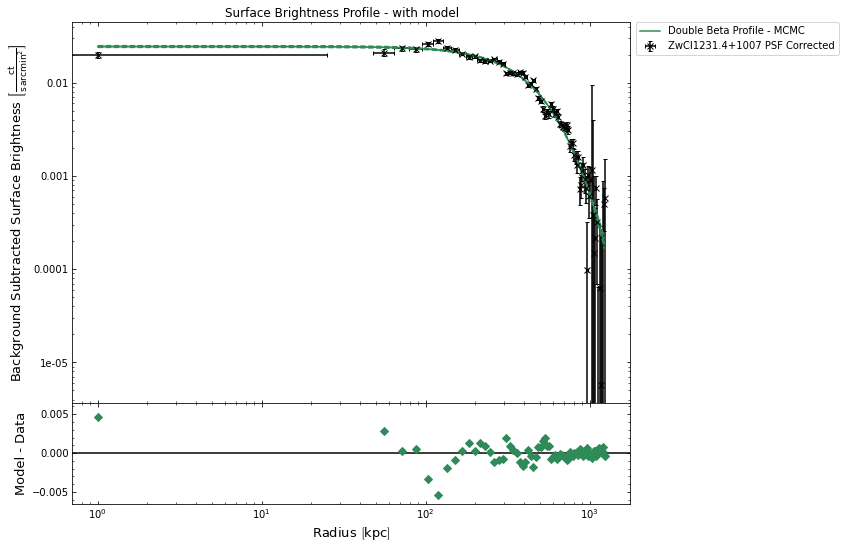

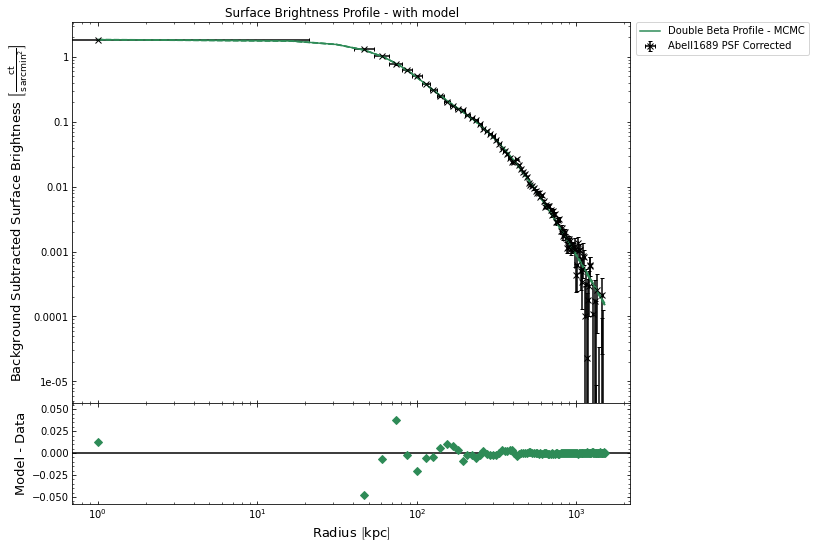

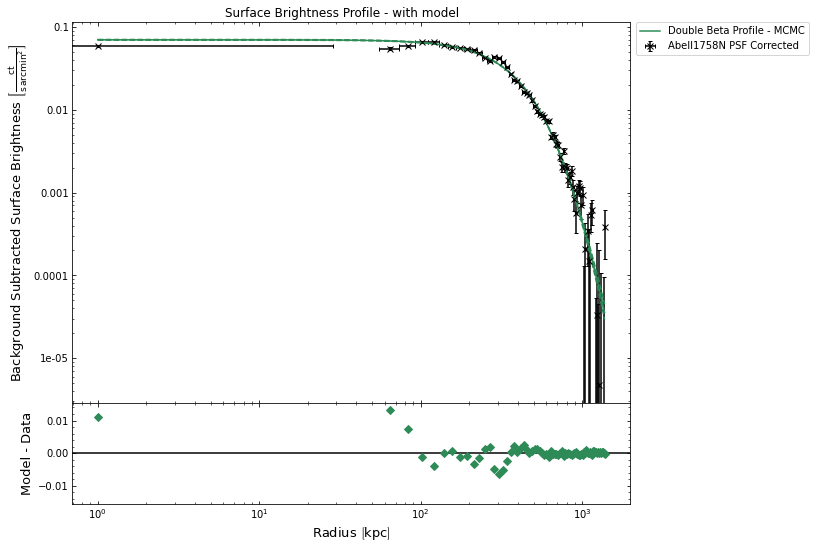

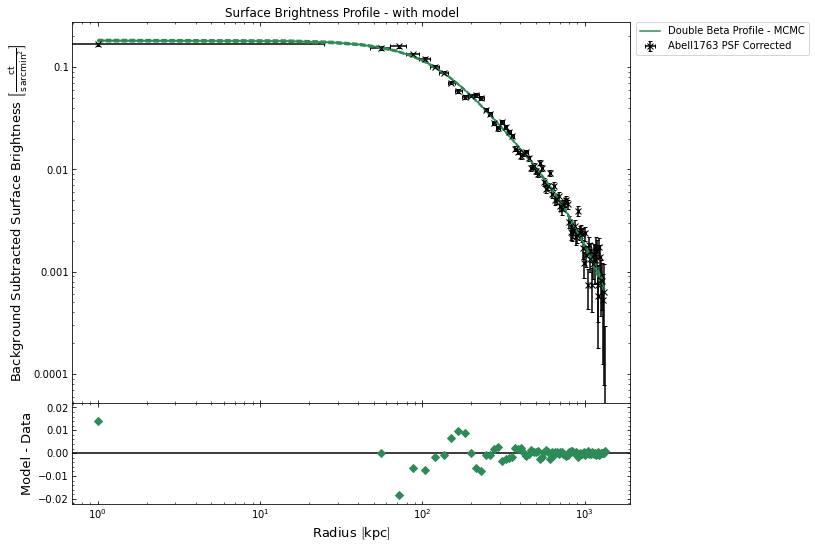

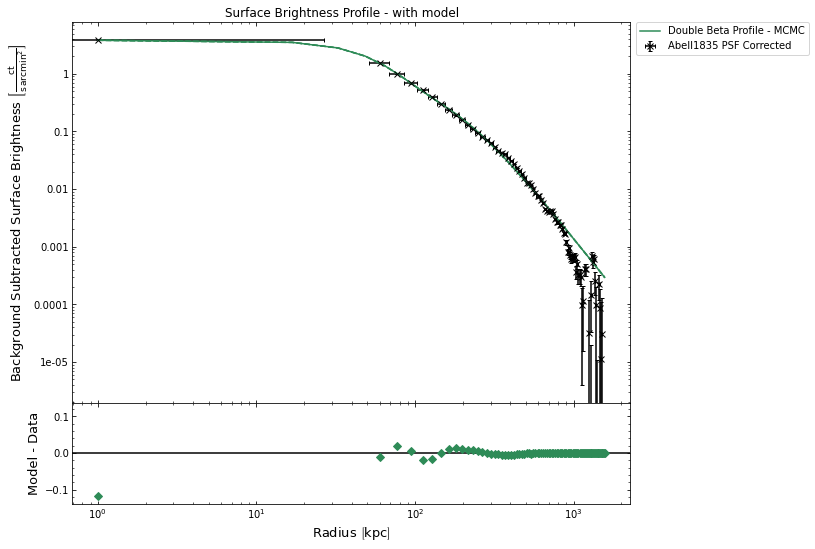

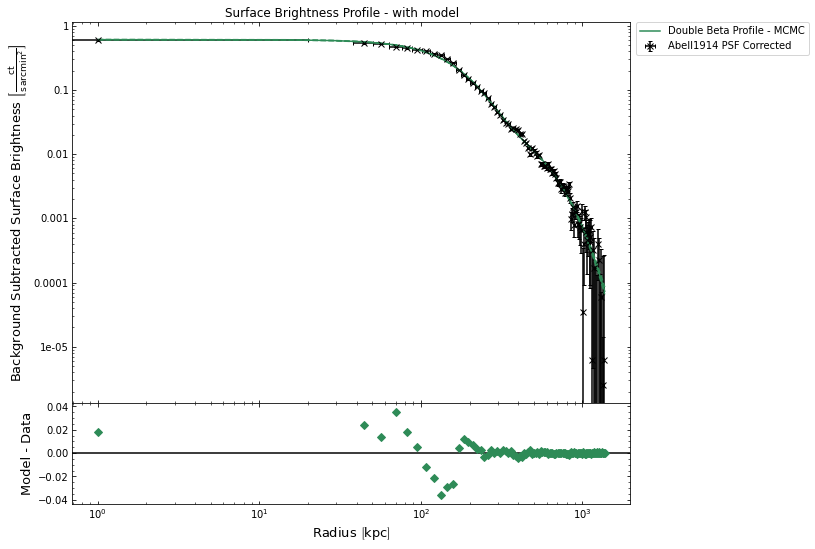

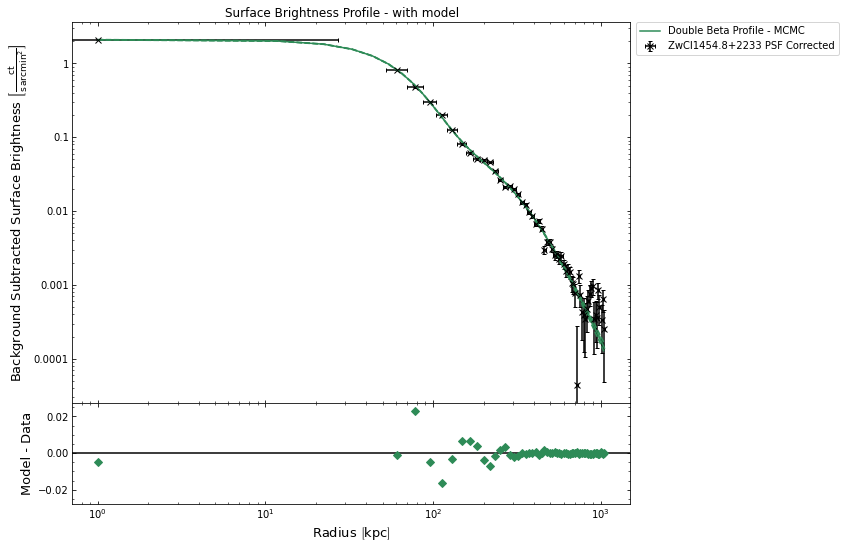

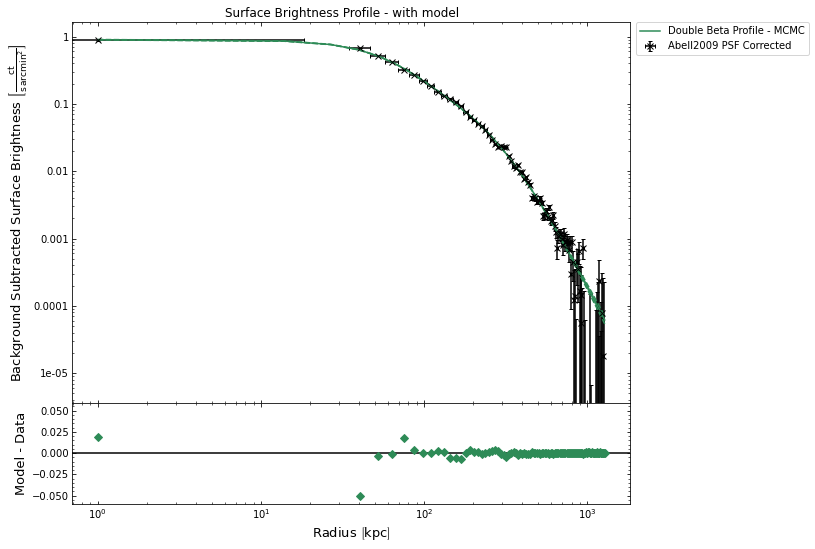

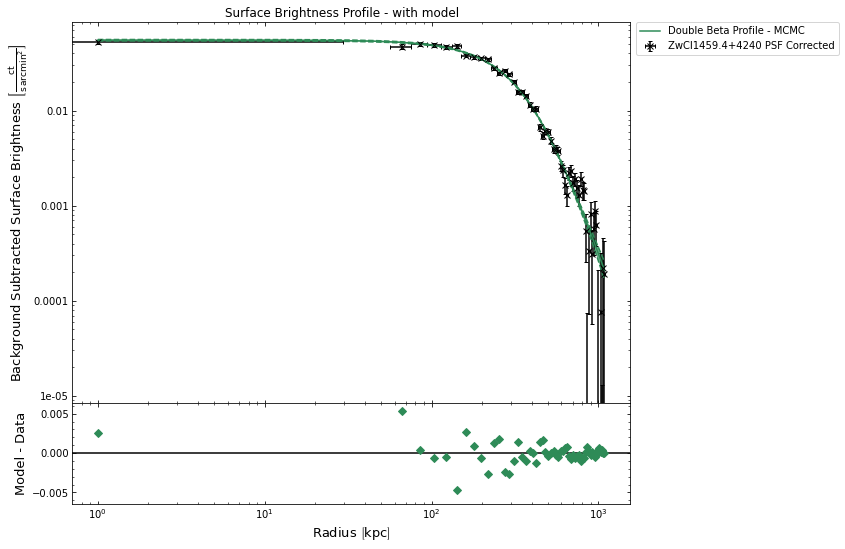

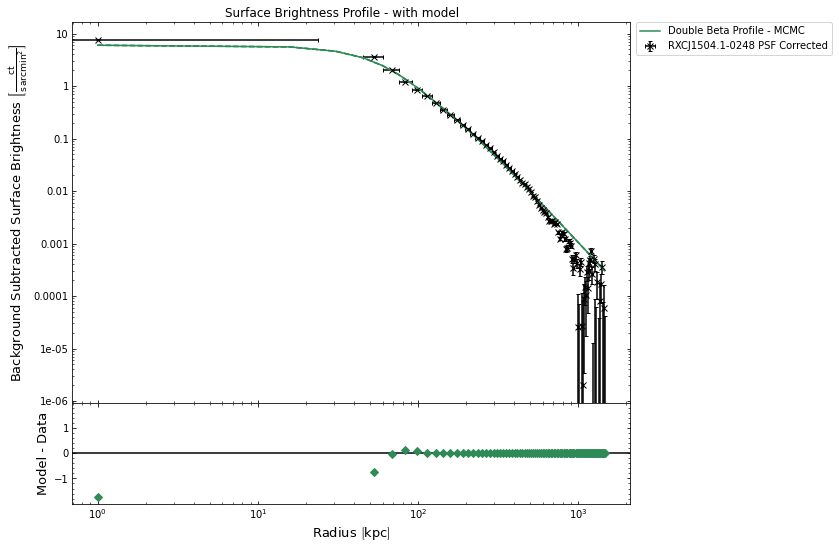

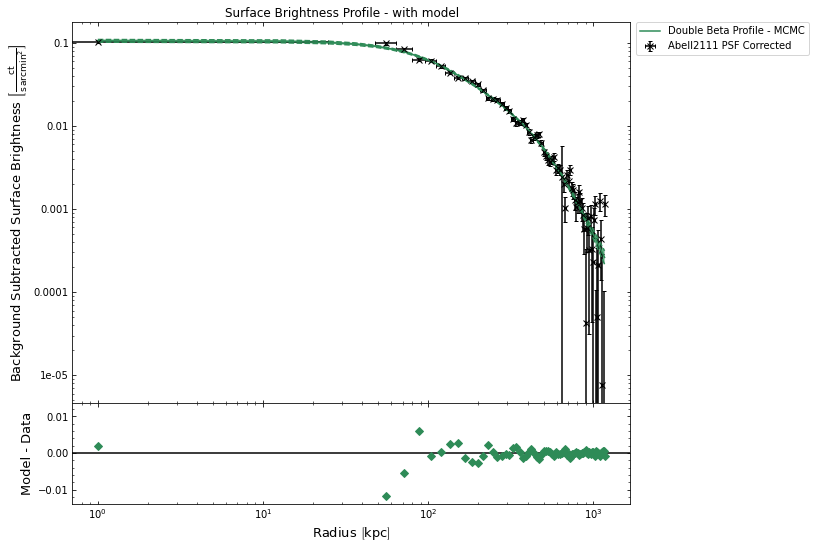

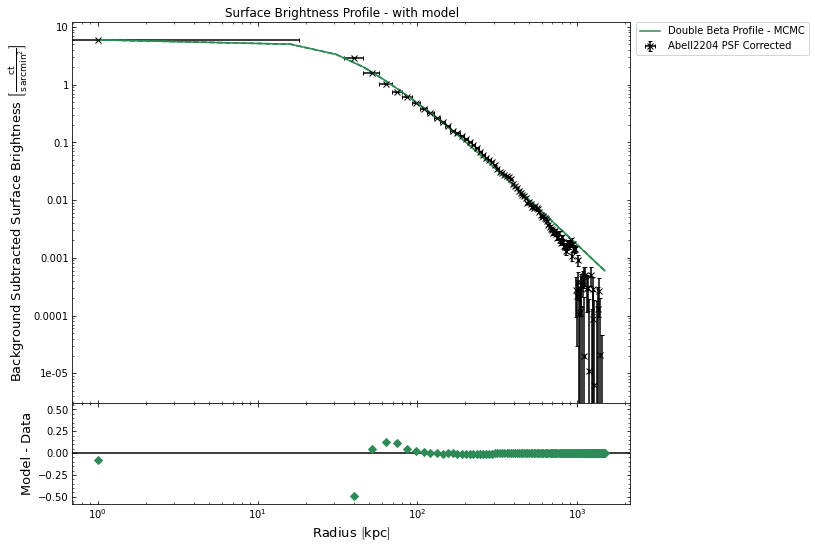

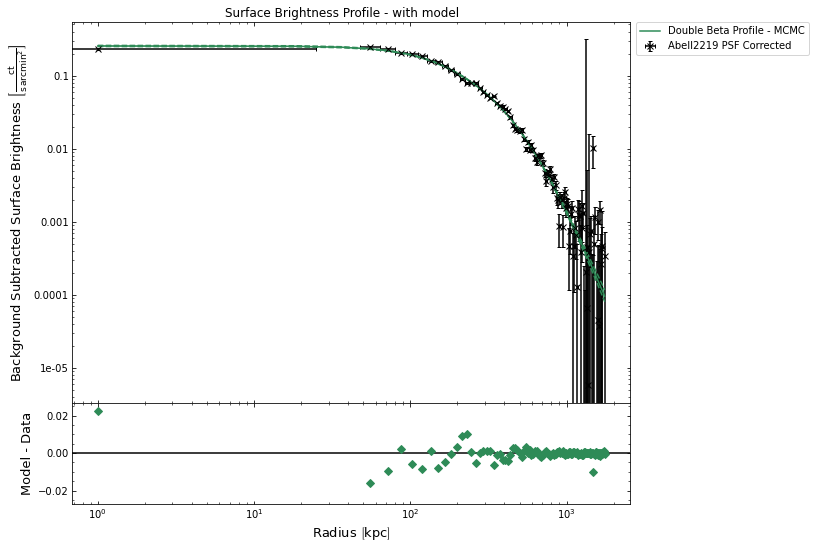

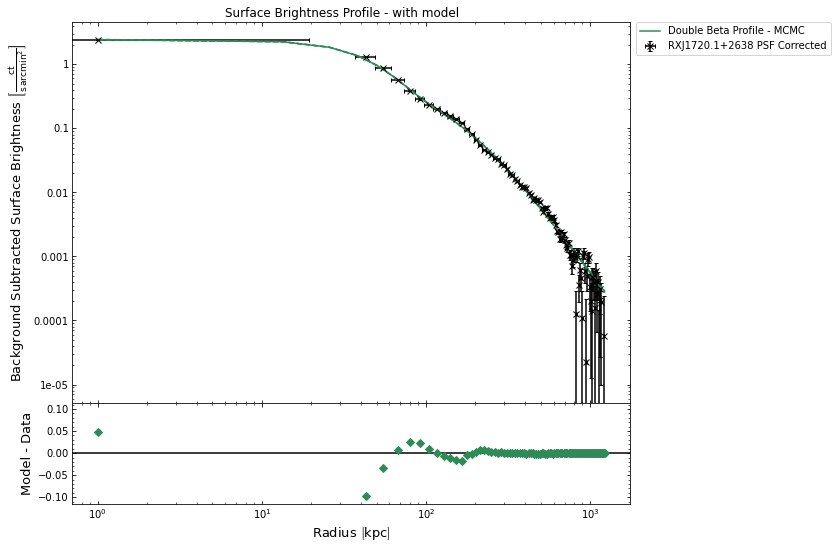

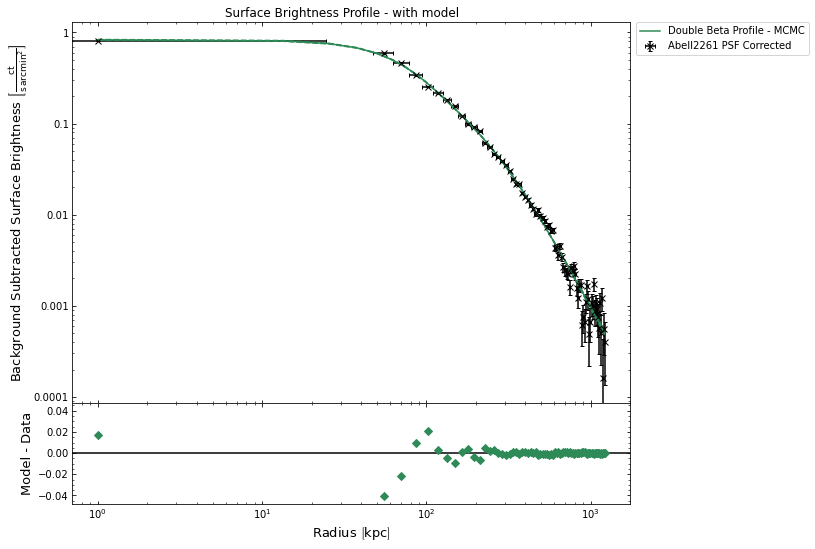

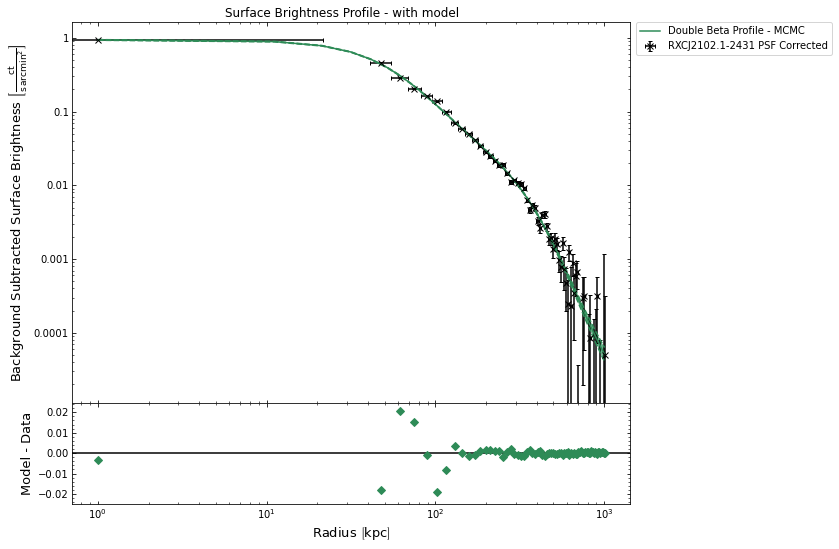

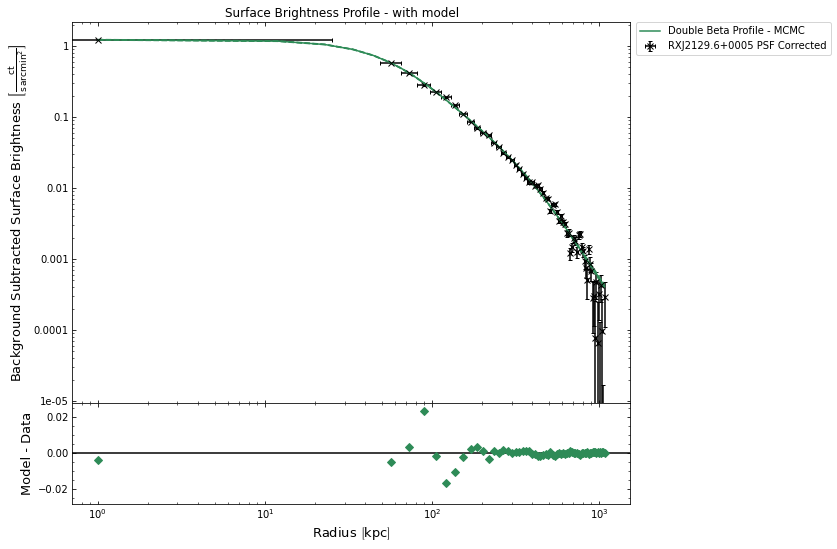

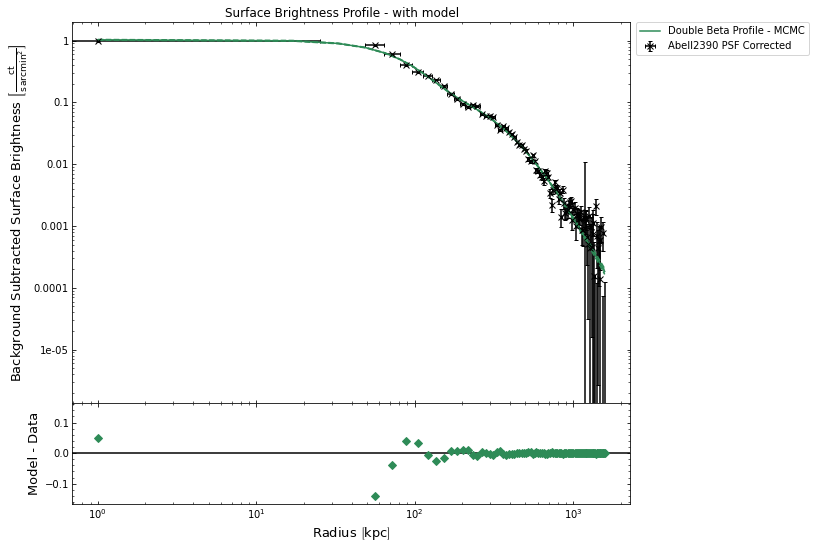

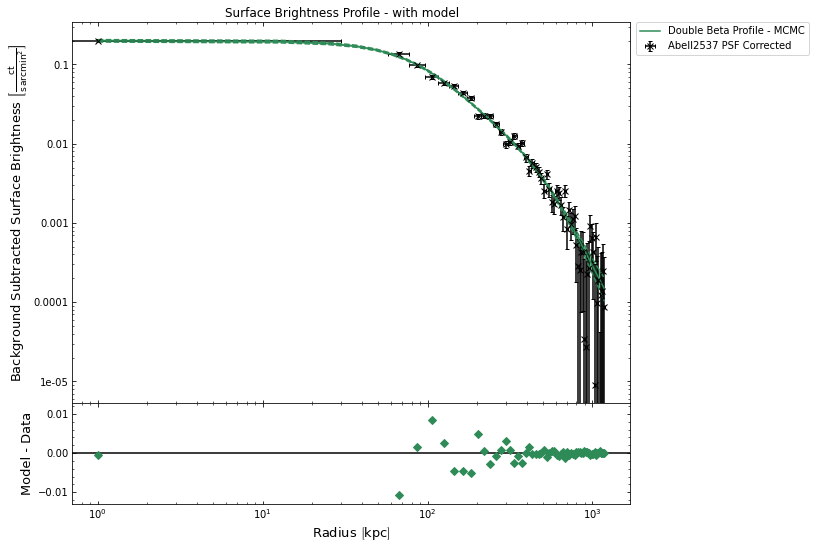

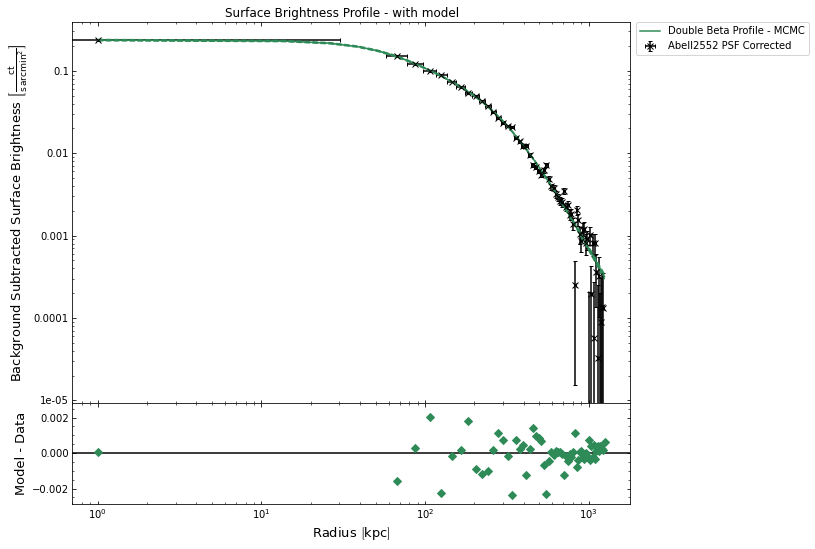

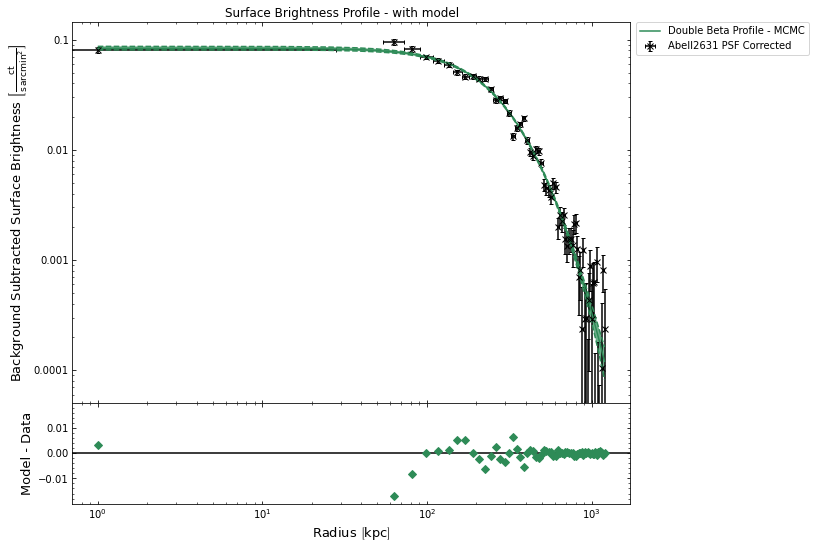

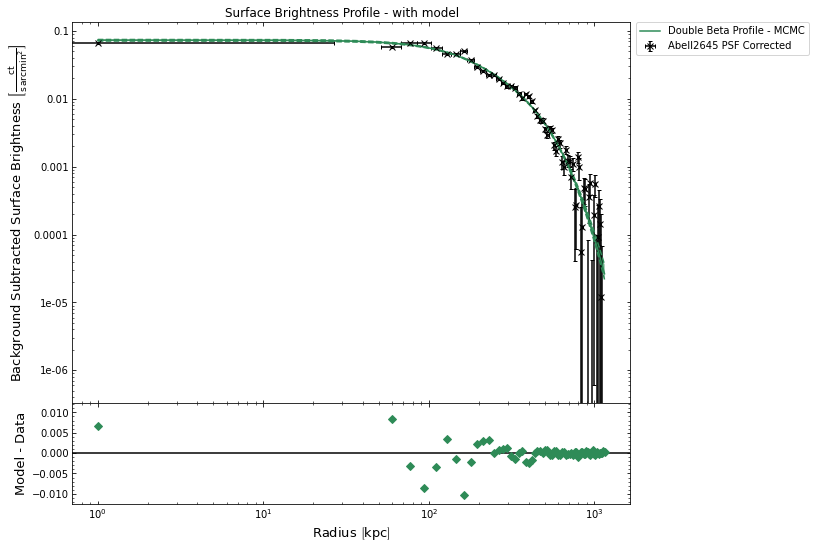

In [22]:
for dp in loc_dblbeta_1r500_dp:
    try:
        dp.generation_profile.view()
    except:
        pass

In [27]:
loc_dblbeta_1r500_dp_npsf = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                                  conv_temp=loc_conv_txs, psf_corr=False)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_dp_npsf)) as onwards:
    for dp in loc_dblbeta_1r500_dp_npsf:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:  11%|███▌                            | 5/45 [03:38<28:32, 42.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [118.25805849 158.66703923 707.53530278 114.8174039  148.99994345
 166.23141377]


Fitting density model to LoCuSS profiles:  16%|████▉                           | 7/45 [05:03<27:11, 42.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [482.4921339  806.25198455 974.87427464 371.29441225 423.83941832
 957.55681349]


Fitting density model to LoCuSS profiles:  18%|█████▋                          | 8/45 [05:46<26:19, 42.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  94.19762871   94.73664421 1160.17350251  106.90157699  115.7974781
   99.38295795]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [07:58<24:42, 43.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2539.27684333 2879.75714484 1865.32062844 2422.4944912  2474.16314876
 2044.80607264]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [11:32<20:09, 41.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [154.85815241 143.72576218 558.05647332 769.2049145  279.87962761
 145.53336555]


Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [12:58<14:09, 32.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 85.02206386  83.39851914 796.28979007  88.84146321  90.00531529
  84.96737262]


Fitting density model to LoCuSS profiles:  51%|███████████████▊               | 23/45 [15:52<14:46, 40.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [110.26100071 113.29853076 788.09783025 112.31914208 105.76939639
 145.67337913]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [18:09<13:50, 43.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [905.13146764 881.32309145 176.63841719 258.33667232 909.08077868
 169.97409787]


Fitting density model to LoCuSS profiles:  60%|██████████████████▌            | 27/45 [18:52<13:02, 43.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 101.36260512  102.66808298 1236.76919829  127.61534115  133.37209535
  109.65937356]


Fitting density model to LoCuSS profiles:  64%|███████████████████▉           | 29/45 [20:23<11:48, 44.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 237.58671338 1063.30512007  762.93766373  197.54472851  203.91955509
  209.78479391]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [22:36<09:38, 44.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1113.18635909 1954.52065071 1171.28059113 1677.2711635  1304.14063263
 1456.77024   ]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [23:24<09:04, 45.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 84.89419388  85.61937155 651.98676204  85.66054441  85.93124818
  61.96929487]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▍       | 34/45 [24:09<08:18, 45.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [304.49718848 532.87970545 800.31124815 200.75234649 152.01219415
 717.12246557]


Fitting density model to LoCuSS profiles:  87%|██████████████████████████▊    | 39/45 [28:07<04:33, 45.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  97.75876048   94.59180441 1049.29008264  111.24355503  119.13565147
   94.15414923]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [30:20<02:13, 44.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [172.41276926 325.09301138 611.53007667 134.71212507 132.15073058
 434.36884696]


Fitting density model to LoCuSS profiles:  96%|█████████████████████████████▌ | 43/45 [31:05<01:29, 44.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 668.24082803 1038.97220695 1134.96943287  503.35706405  640.64184967
 1180.92989298]


Fitting density model to LoCuSS profiles:  98%|██████████████████████████████▎| 44/45 [31:48<00:44, 44.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1597.97220799 1488.03080899 1071.4459888  1564.87202184  390.35393541
 1232.77500361]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [32:30<00:00, 43.36s/it]


In [28]:
loc_dblbeta_svikh_1r500_npsf_gm500 = []
loc_dblbeta_svikh_1r500_npsf_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_dp_npsf)) as onwards:
    for dp in loc_dblbeta_1r500_dp_npsf:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_1r500_npsf_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_1r500_npsf_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_1r500_npsf_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_1r500_npsf_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_1r500_npsf_gm500 = Quantity(loc_dblbeta_svikh_1r500_npsf_gm500, 'Msun')
loc_dblbeta_svikh_1r500_npsf_gm2500 = Quantity(loc_dblbeta_svikh_1r500_npsf_gm2500, 'Msun')

Calculating LoCuSS gas masses:   0%|                                                   | 0/45 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:512: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:09<00:00,  9.55s/it]


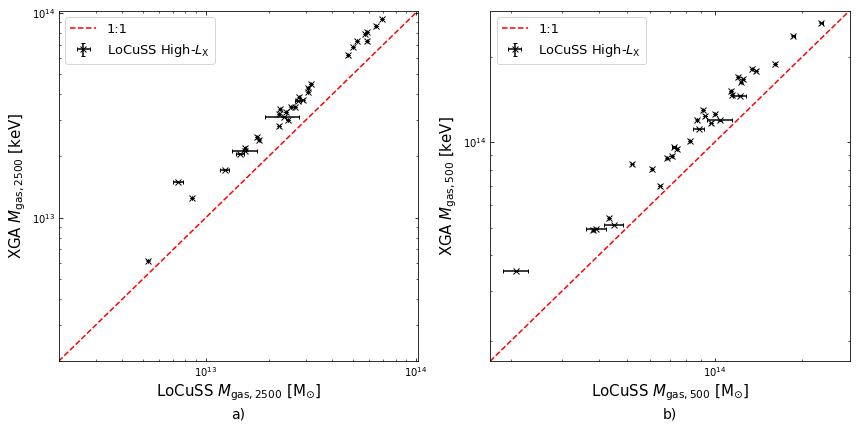

In [46]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_1r500_npsf_gm2500, 
                                                        loc_dblbeta_svikh_1r500_npsf_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])

In [30]:
loc_dblbeta_1r500_5px_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                                  conv_temp=loc_conv_txs, pix_step=5)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_5px_dp)) as onwards:
    for dp in loc_dblbeta_1r500_5px_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   4%|█▍                              | 2/45 [01:13<26:23, 36.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1526.74366495 1646.74312132 1976.88143016 1375.25041769 1030.9480031
 1858.8229698 ]


Fitting density model to LoCuSS profiles:   9%|██▊                             | 4/45 [02:23<24:06, 35.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [815.87668557 849.7769372  827.21042151 700.16368037 476.36153257
 820.09471224]


Fitting density model to LoCuSS profiles:  16%|████▉                           | 7/45 [04:10<22:41, 35.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2260.85347555 2441.51954816 1158.41619953 1793.18504026 2235.59280264
 2480.80561702]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [06:30<19:53, 35.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1079.77279995 1188.17680116  851.69228908 1154.3947585  1140.4540084
  988.27324145]


Fitting density model to LoCuSS profiles:  27%|████████▎                      | 12/45 [07:07<19:35, 35.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 601.04033972  718.50190133 1005.78747034  430.8270704   183.1610204
  871.69452593]


Fitting density model to LoCuSS profiles:  29%|████████▉                      | 13/45 [07:42<18:56, 35.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1875.13908126 2377.46856652 2484.95427136  894.04829609  663.86108182
 2491.01810677]


Fitting density model to LoCuSS profiles:  31%|█████████▋                     | 14/45 [08:19<18:32, 35.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 455.51021221 1236.87591225 1816.19433535  258.64285256  135.39876375
 1725.85114507]


Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [10:47<12:18, 28.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1174.71388991 1385.53981848 1454.13967269  816.78886639  461.07473975
 1456.78974128]


Fitting density model to LoCuSS profiles:  47%|██████████████▍                | 21/45 [12:01<12:50, 32.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1054.93336545 1809.88762279 2934.37757343  677.55345922  336.56830148
 1913.22447686]


Fitting density model to LoCuSS profiles:  49%|███████████████▏               | 22/45 [12:36<12:37, 32.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [104.74481666 120.05548408 784.53528697 107.68691923 102.1929141
 115.75883717]


Fitting density model to LoCuSS profiles:  53%|████████████████▌              | 24/45 [13:46<11:51, 33.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [505.46287566 510.7811461  276.19116339 773.43550951 490.18996658
 377.5344488 ]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [14:58<11:00, 34.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [947.84612911 951.57045669 401.77352253 891.6426227  809.15599017
 445.13917052]


Fitting density model to LoCuSS profiles:  62%|███████████████████▎           | 28/45 [16:10<09:58, 35.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 93.29091103  95.22810236 816.16637539  99.7027338  137.97801845
 104.81291913]


Fitting density model to LoCuSS profiles:  64%|███████████████████▉           | 29/45 [16:45<09:22, 35.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2054.0162255  2915.45867647  549.1409299  1157.59006851 2236.52003695
  171.69421551]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [17:21<08:49, 35.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 114.45341992  402.57771708 1076.98199098  109.35941665  110.5956038
  884.1219908 ]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▍       | 34/45 [19:14<05:34, 30.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1977.66257631 2342.13771115 2872.09570502 1583.52149576  970.26973283
 2570.66755643]


Fitting density model to LoCuSS profiles:  82%|█████████████████████████▍     | 37/45 [21:11<04:46, 35.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2388.35987835 2577.88639724 2167.78920046 2407.48231054 2422.10574284
 2314.37979563]


Fitting density model to LoCuSS profiles:  84%|██████████████████████████▏    | 38/45 [21:51<04:19, 37.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [452.00940918 543.7734355  596.88511456 615.22902904 603.6877099
 611.84203305]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [24:15<01:49, 36.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1100.06529184 1410.72073058 2917.18714836  585.35948655  362.54561497
 1490.10476199]


Fitting density model to LoCuSS profiles:  96%|█████████████████████████████▌ | 43/45 [24:49<01:11, 35.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1858.62612904 1738.17219269  622.65672406 1637.27156261  738.27244387
 1401.56333775]


Fitting density model to LoCuSS profiles:  98%|██████████████████████████████▎| 44/45 [25:24<00:35, 35.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [876.17424835 705.17977941 633.2603053  687.27028839 416.42535625
 674.81580054]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [25:59<00:00, 34.66s/it]


In [31]:
loc_dblbeta_svikh_1r500_5px_gm500 = []
loc_dblbeta_svikh_1r500_5px_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_5px_dp)) as onwards:
    for dp in loc_dblbeta_1r500_5px_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_1r500_5px_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_1r500_5px_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_1r500_5px_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_1r500_5px_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_1r500_5px_gm500 = Quantity(loc_dblbeta_svikh_1r500_5px_gm500, 'Msun')
loc_dblbeta_svikh_1r500_5px_gm2500 = Quantity(loc_dblbeta_svikh_1r500_5px_gm2500, 'Msun')

Calculating LoCuSS gas masses:   0%|                                                   | 0/45 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:512: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:46<00:00, 10.37s/it]


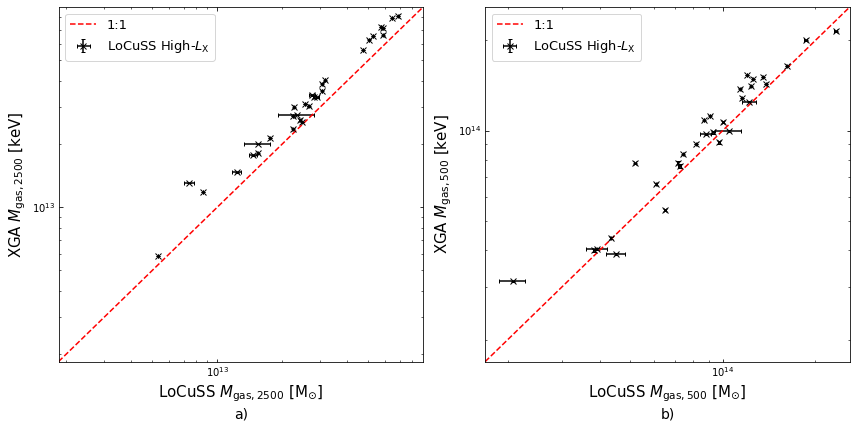

In [43]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_1r500_5px_gm2500, 
                                                        loc_dblbeta_svikh_1r500_5px_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])

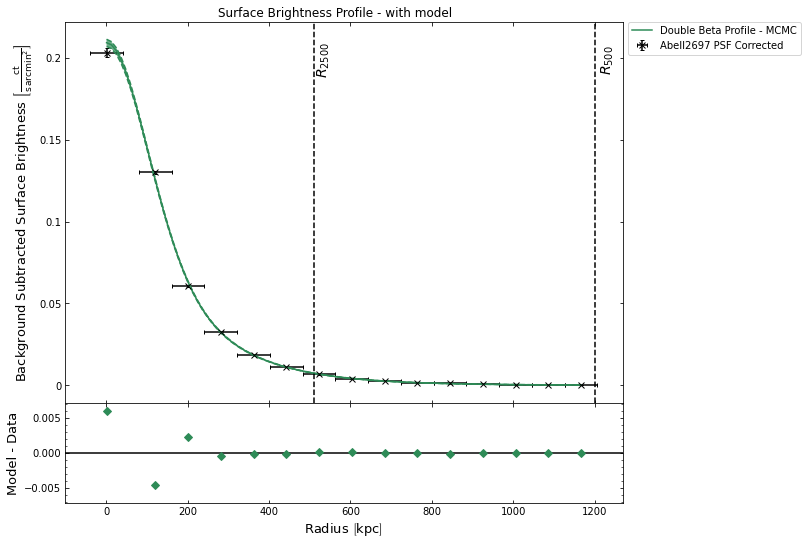

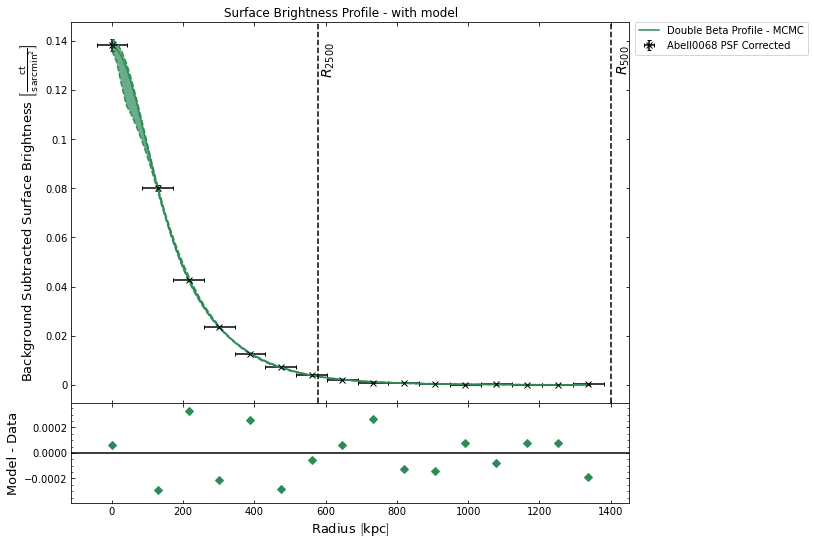

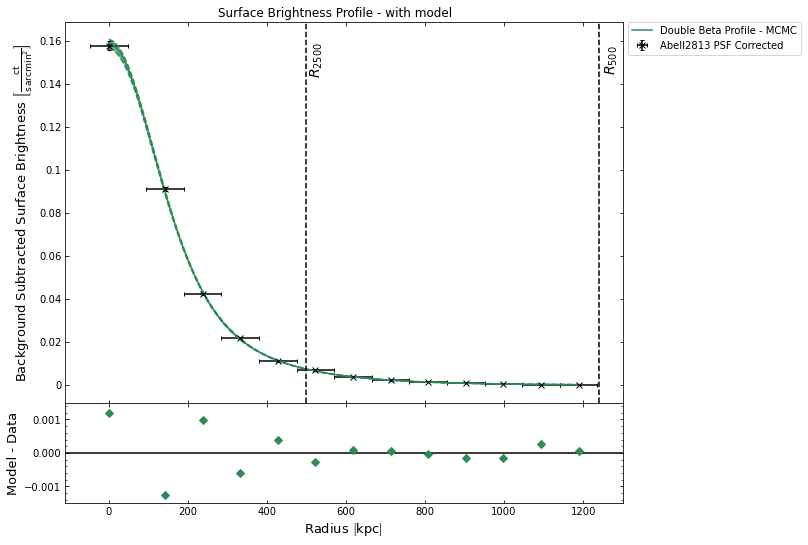

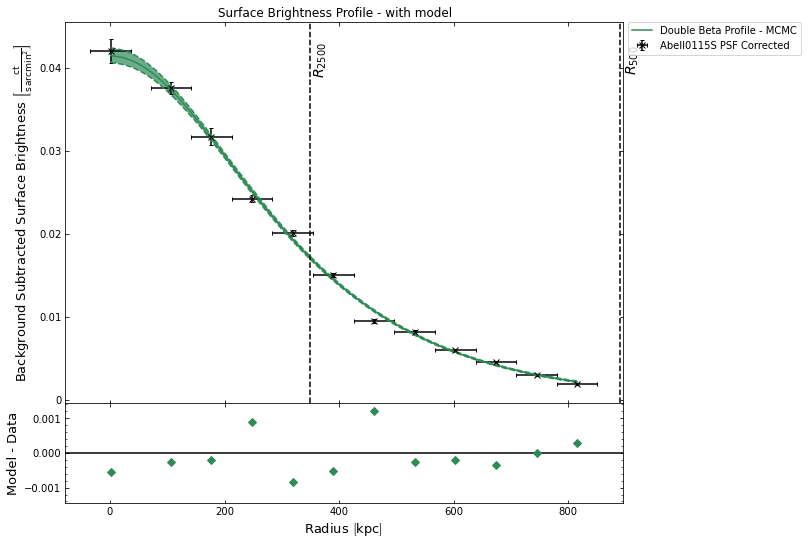

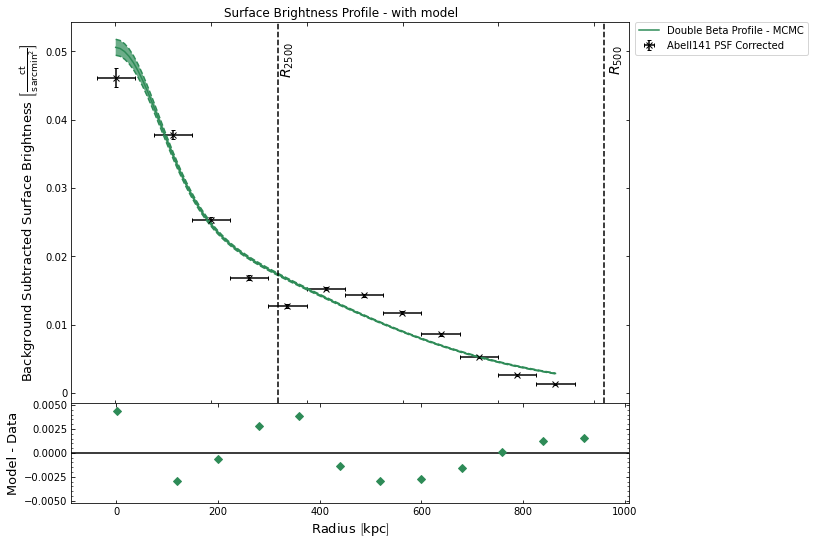

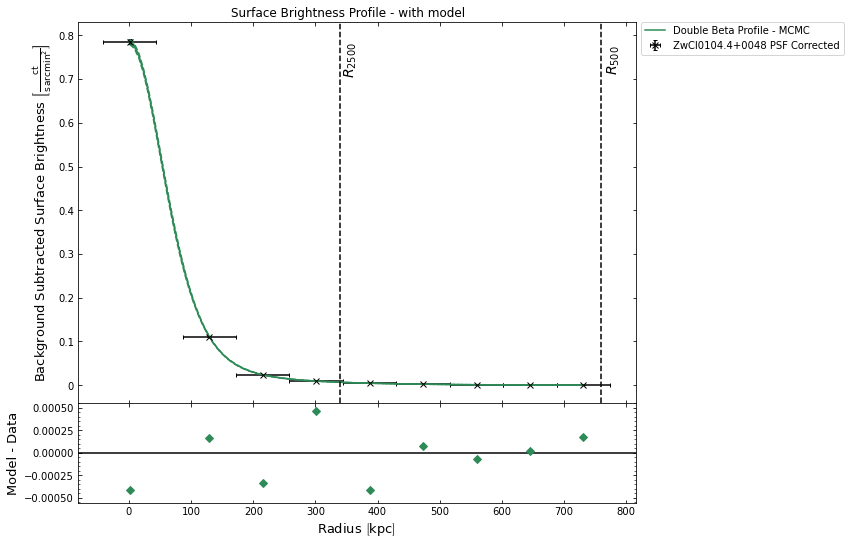

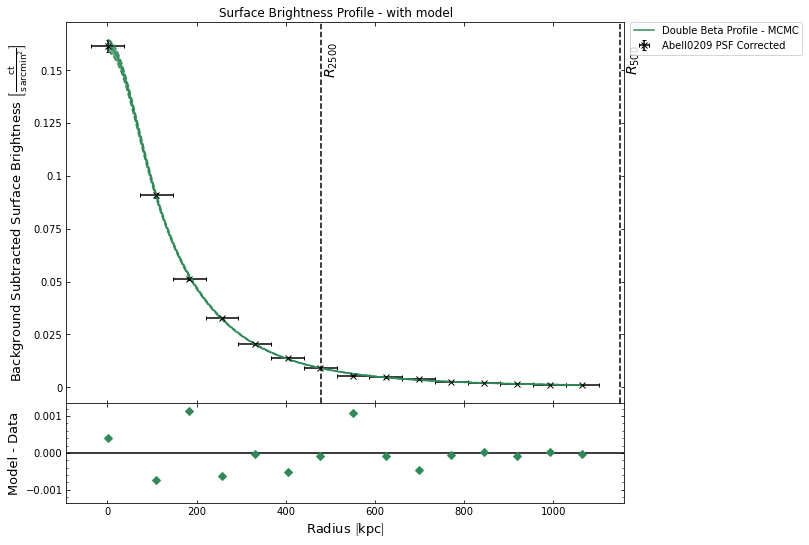

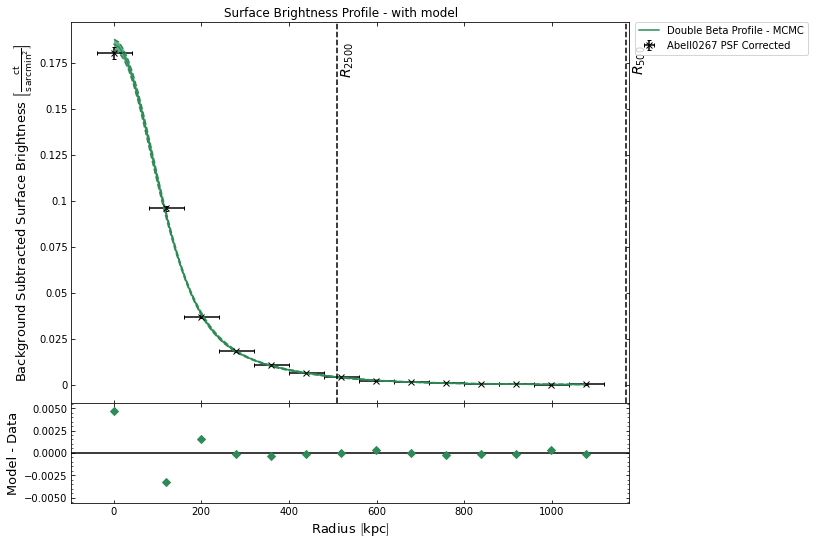

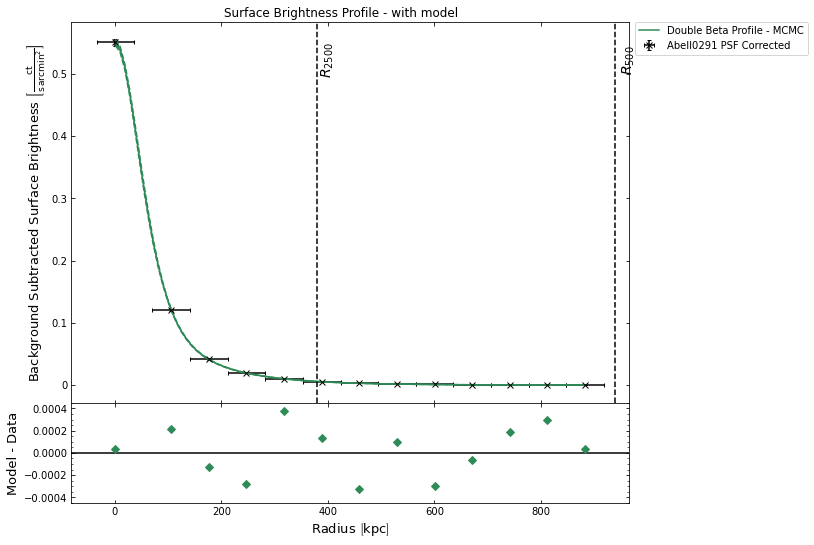

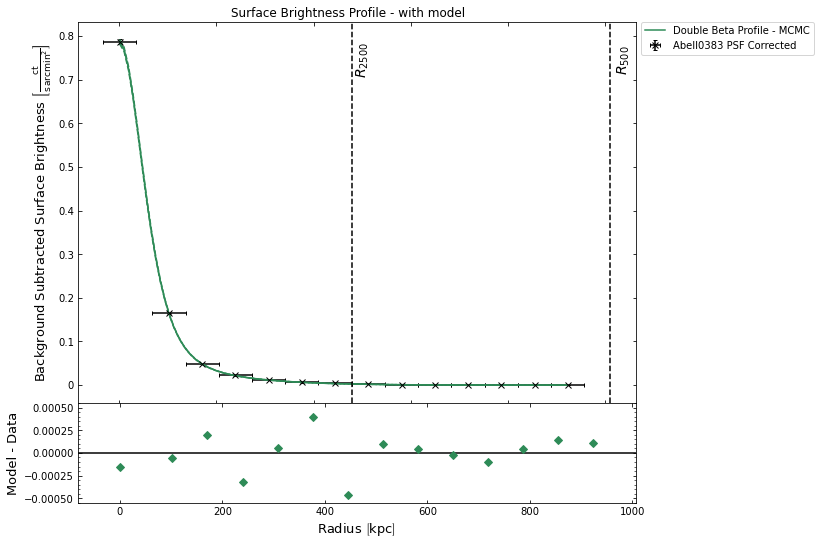

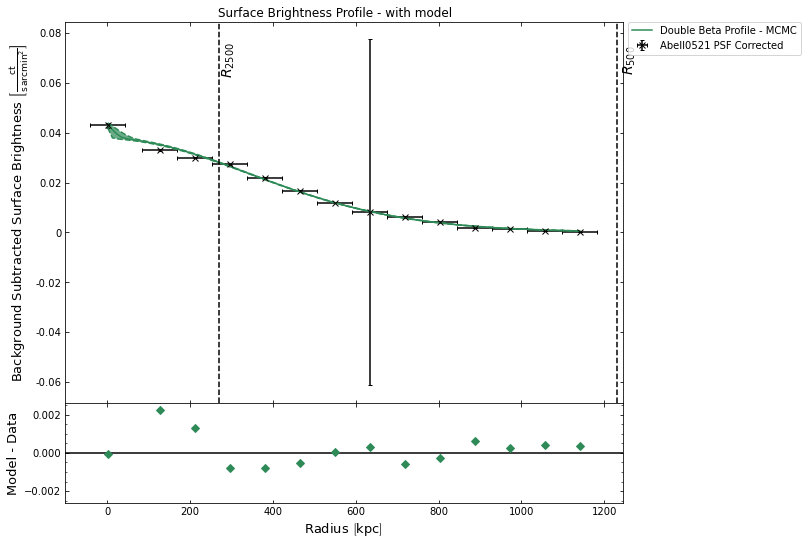

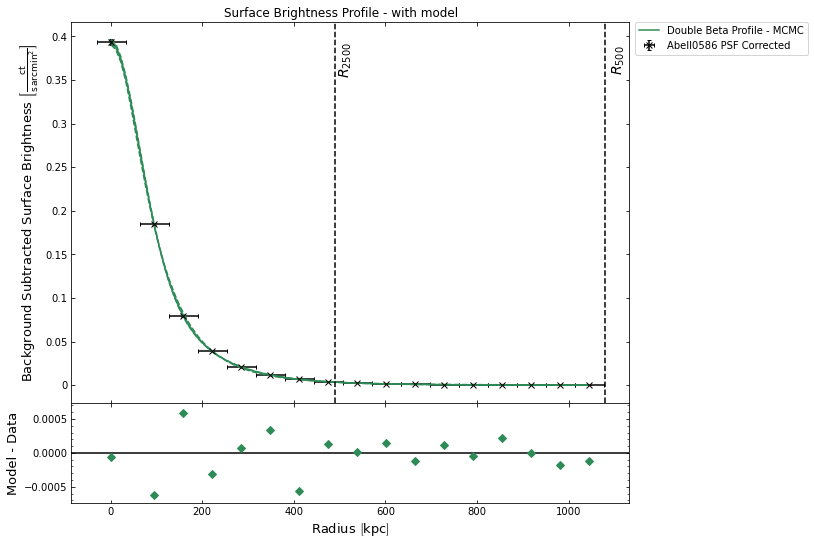

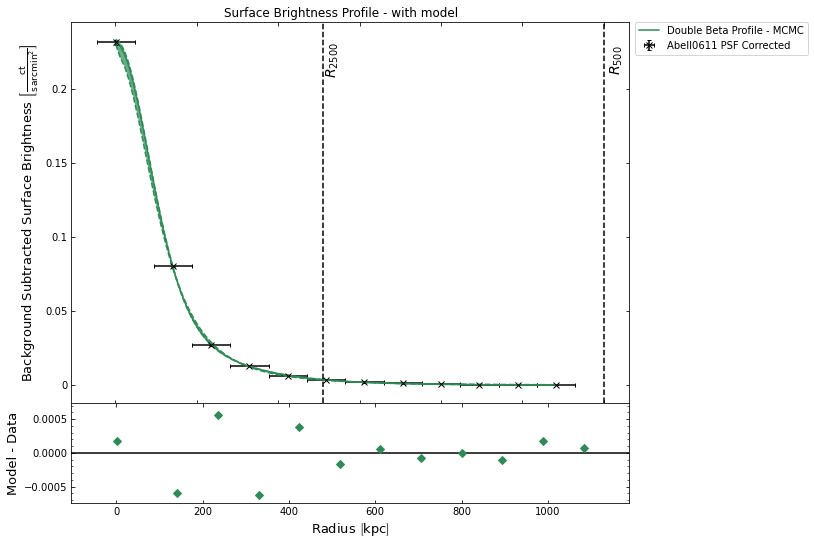

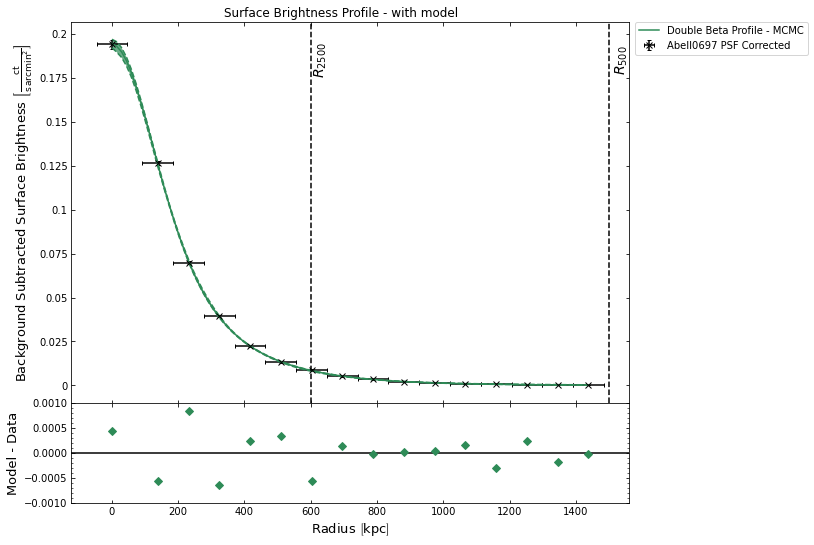

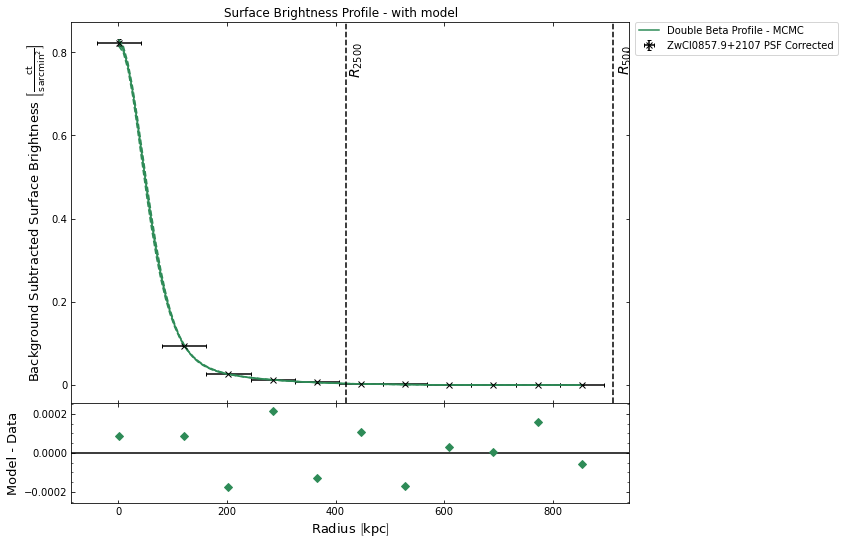

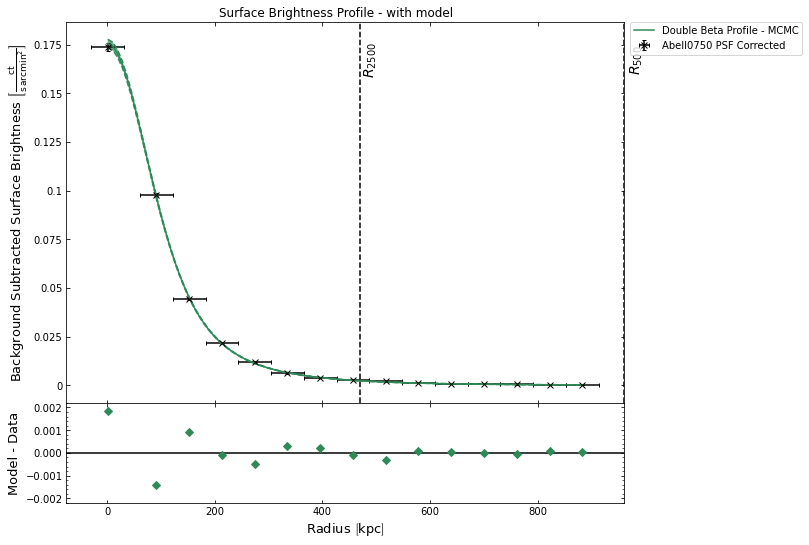

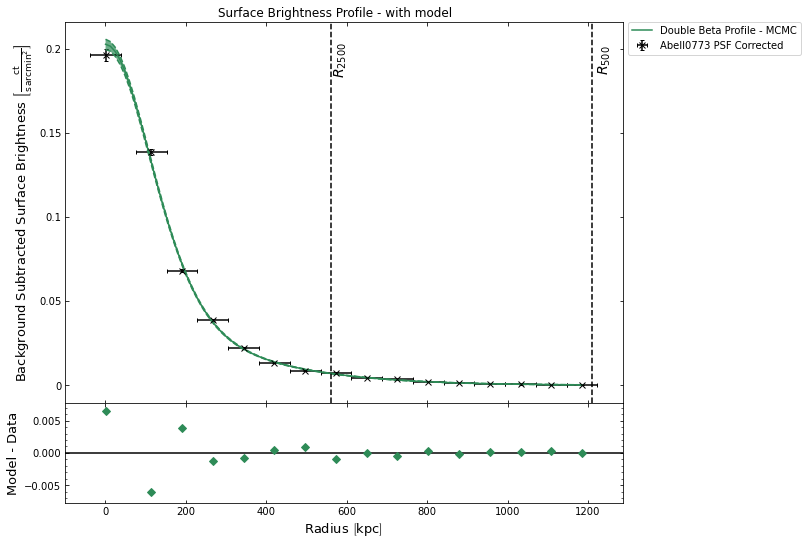

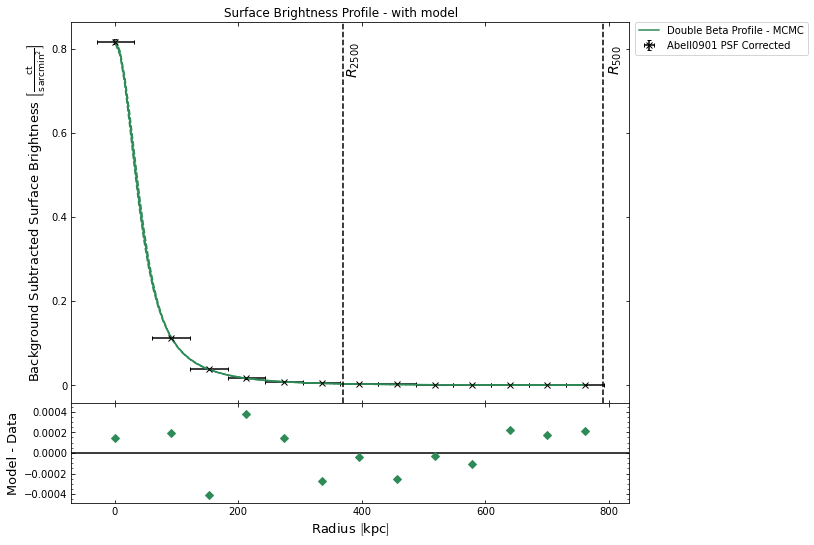

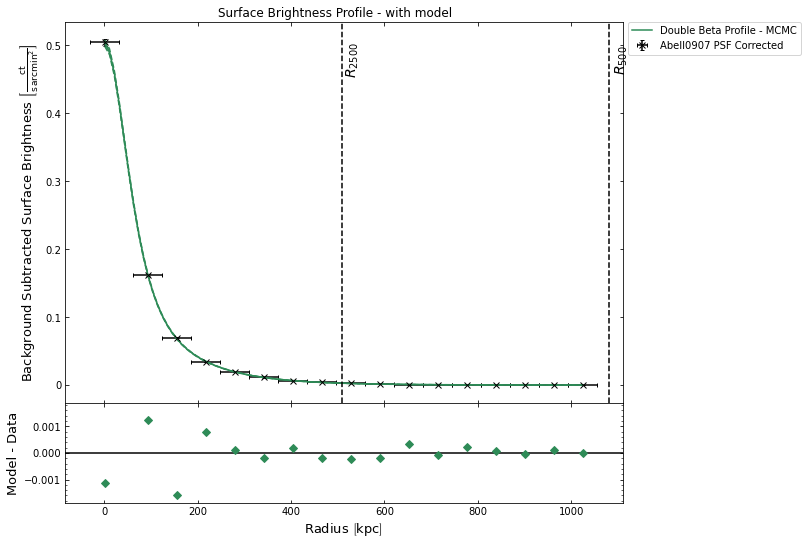

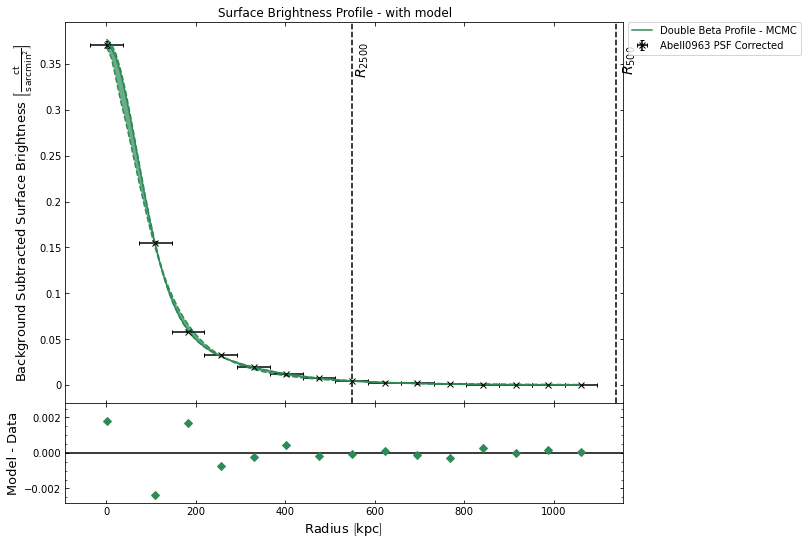

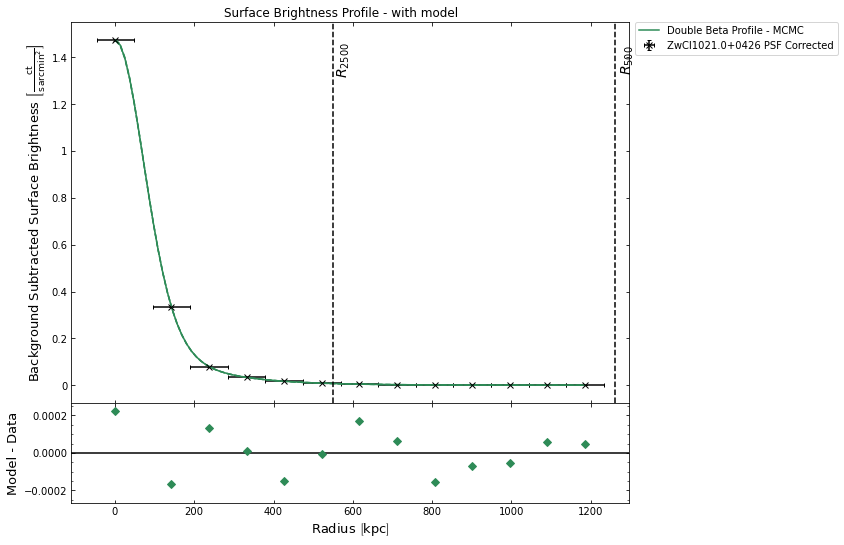

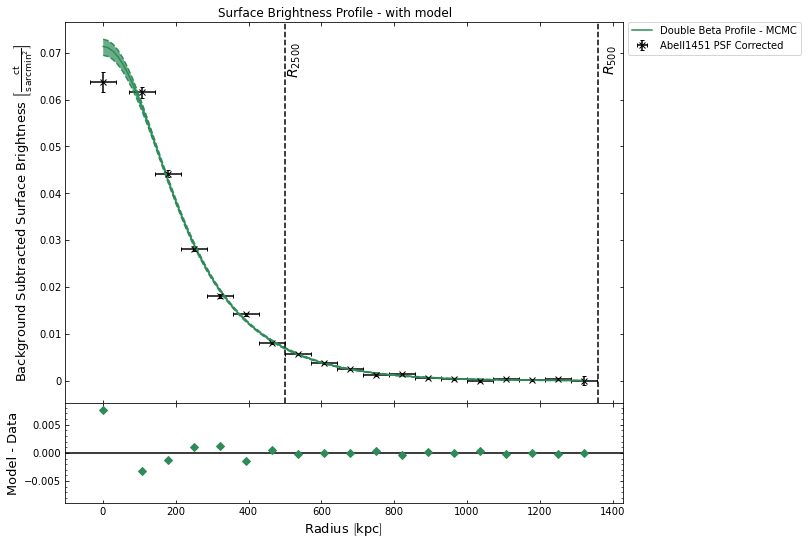

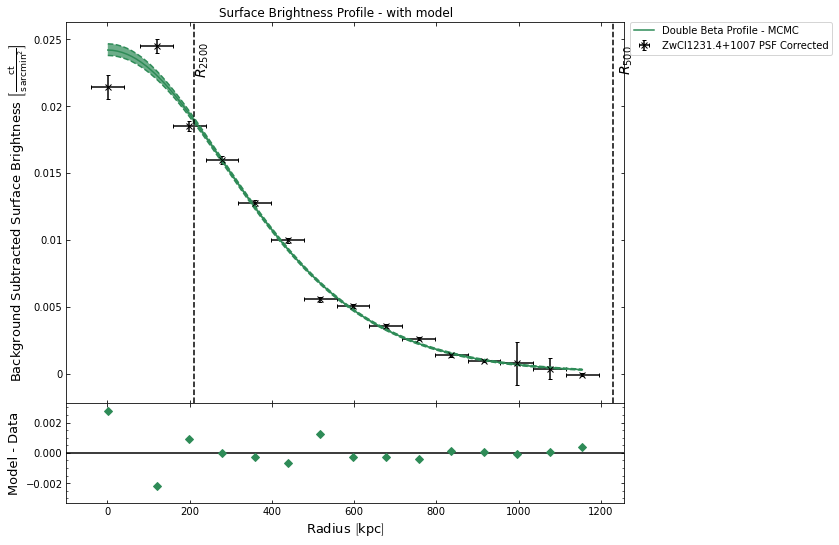

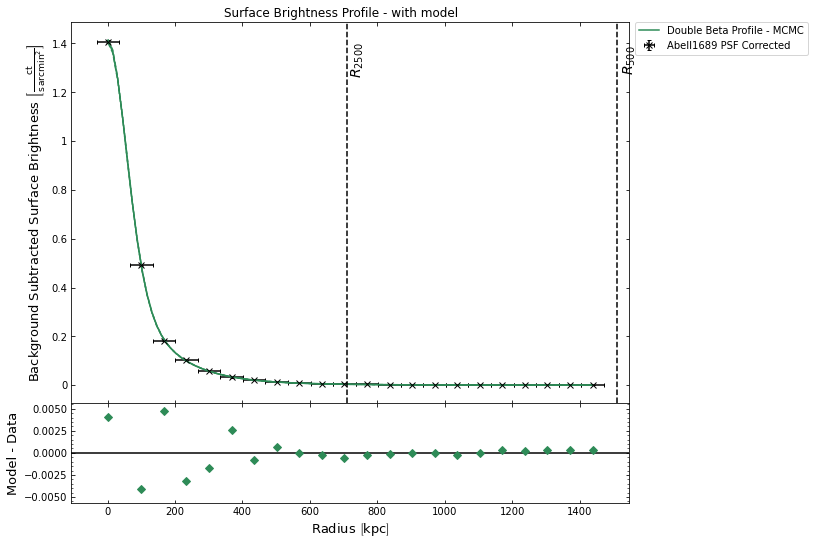

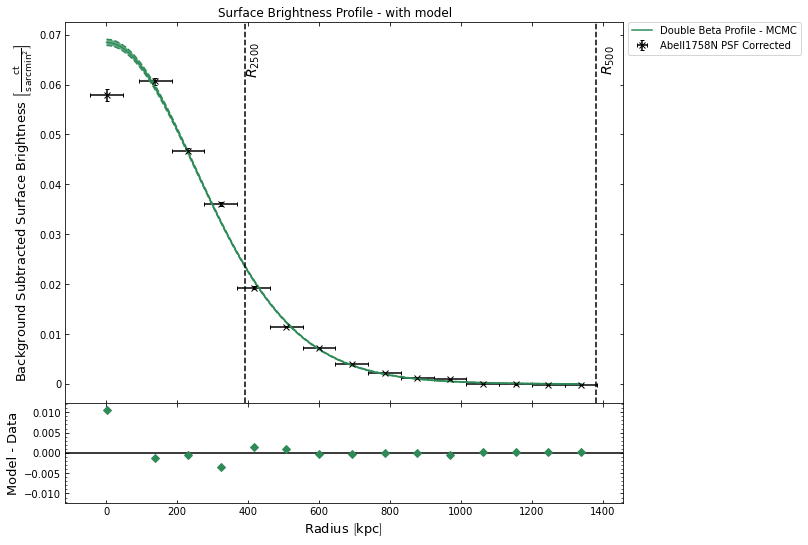

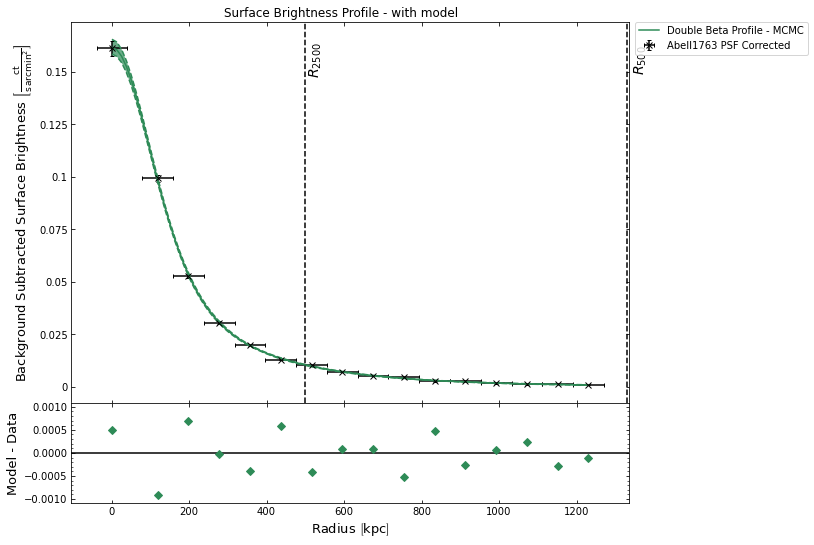

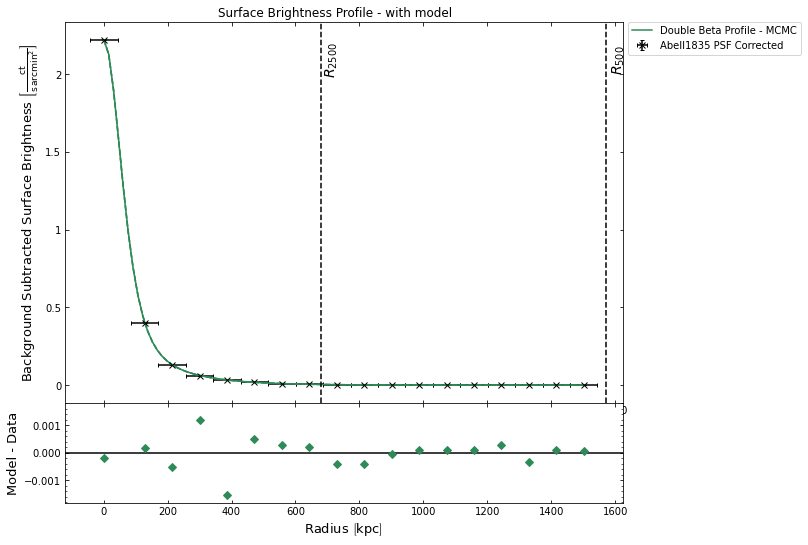

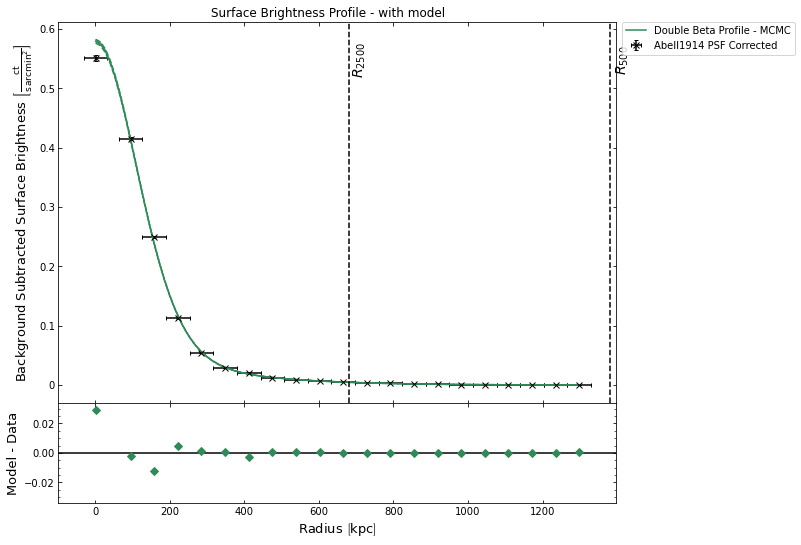

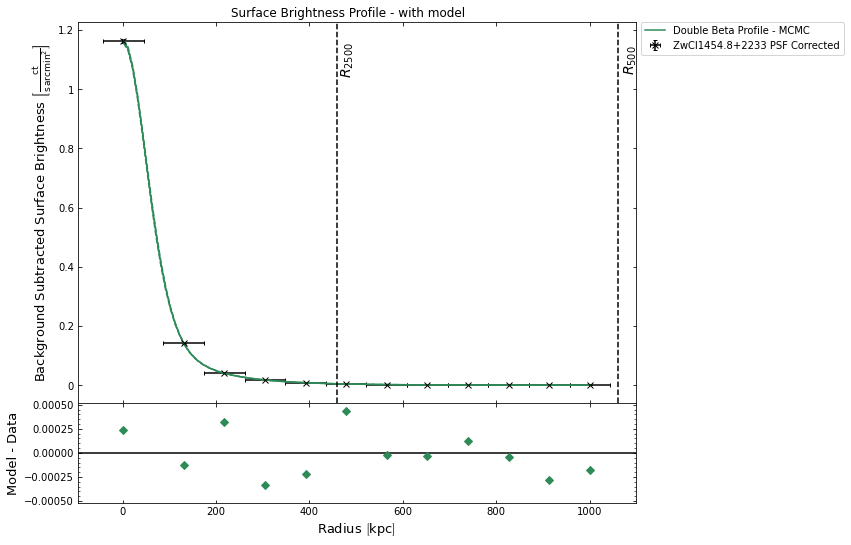

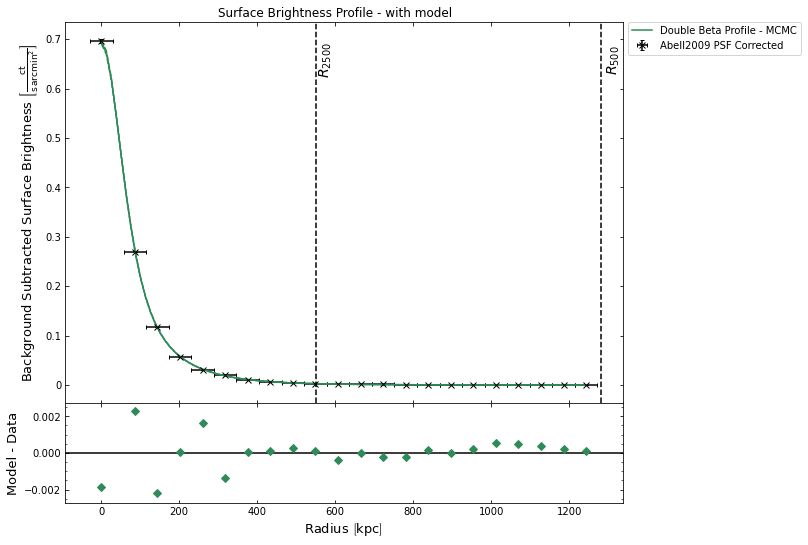

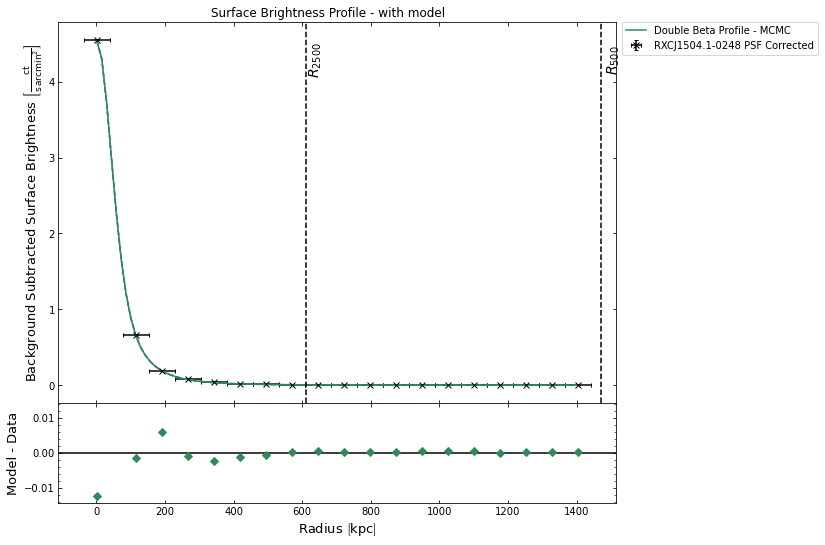

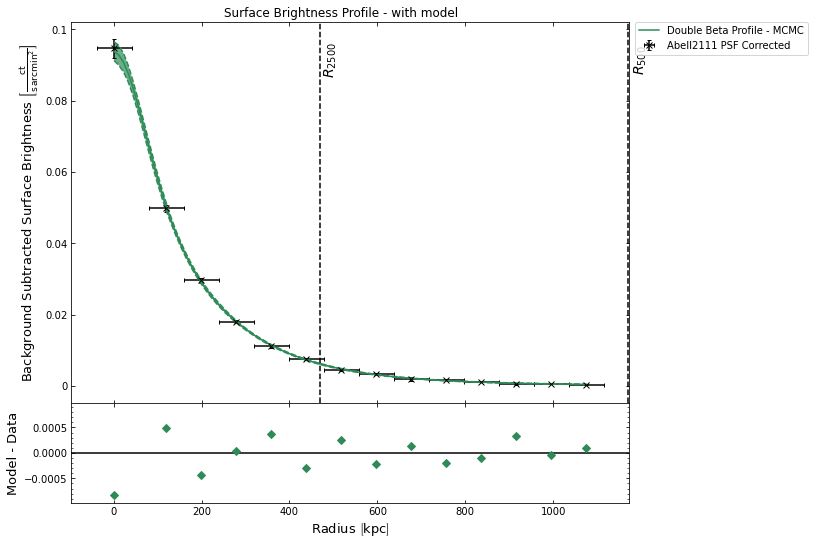

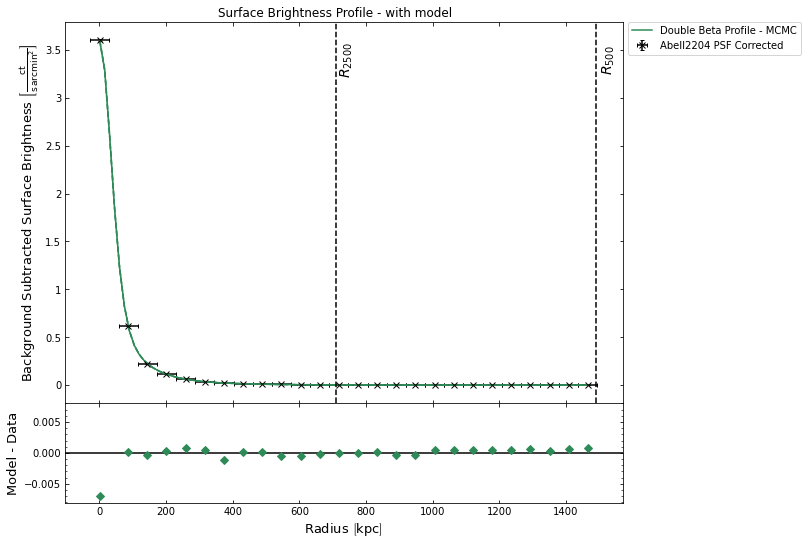

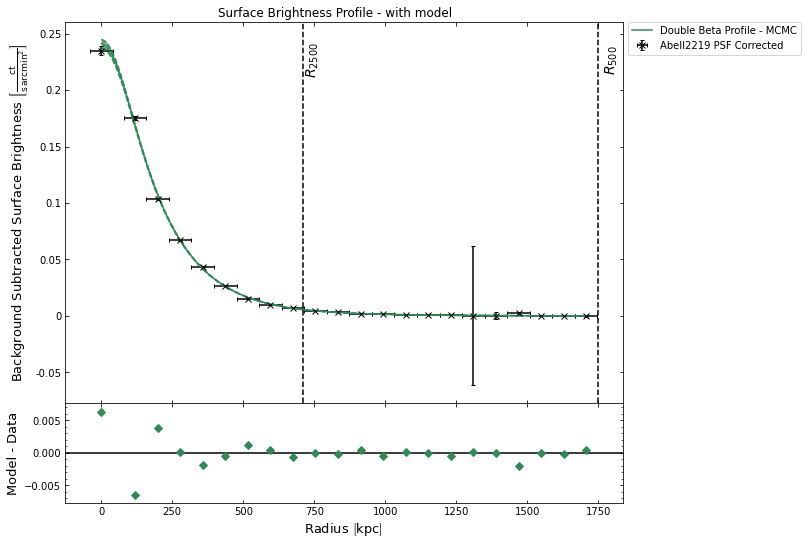

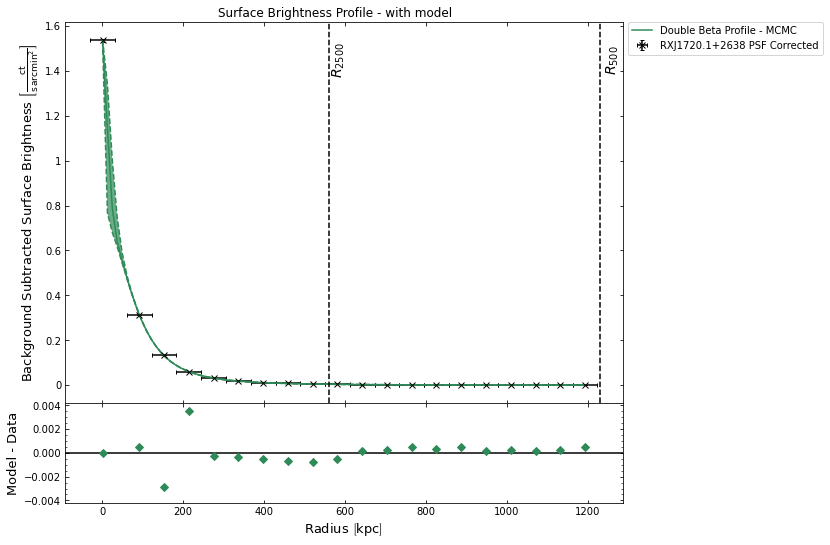

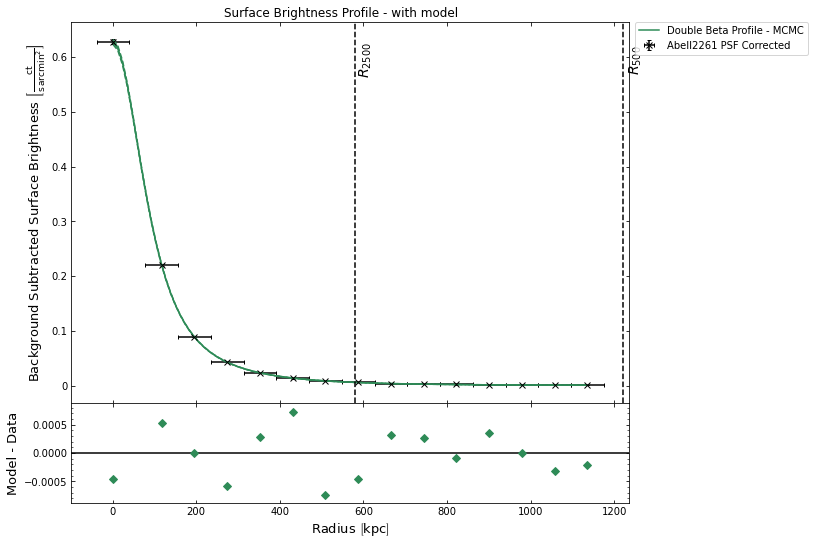

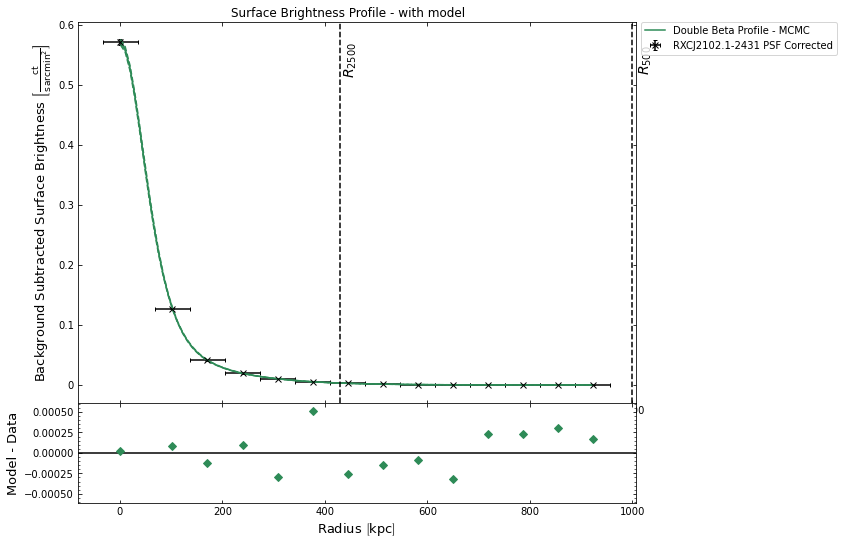

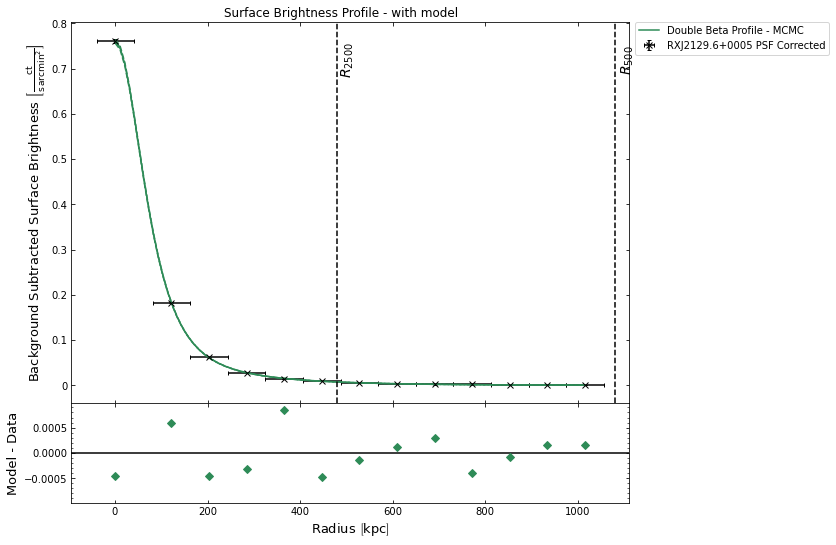

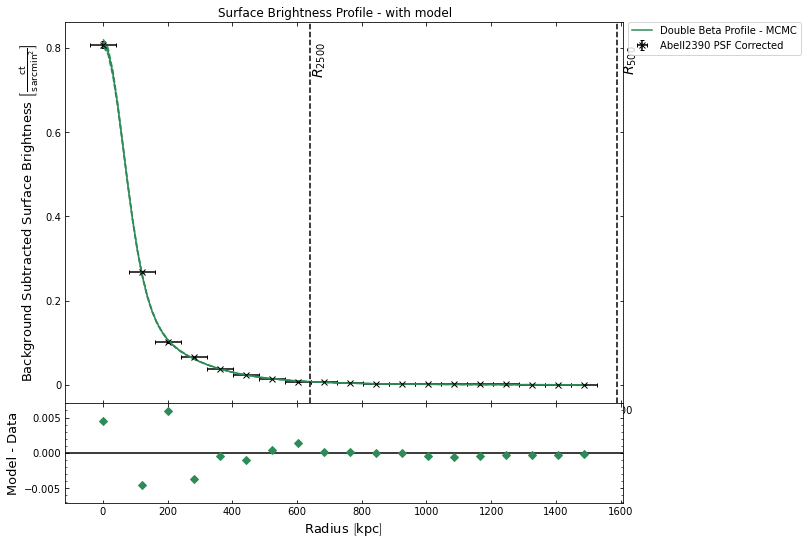

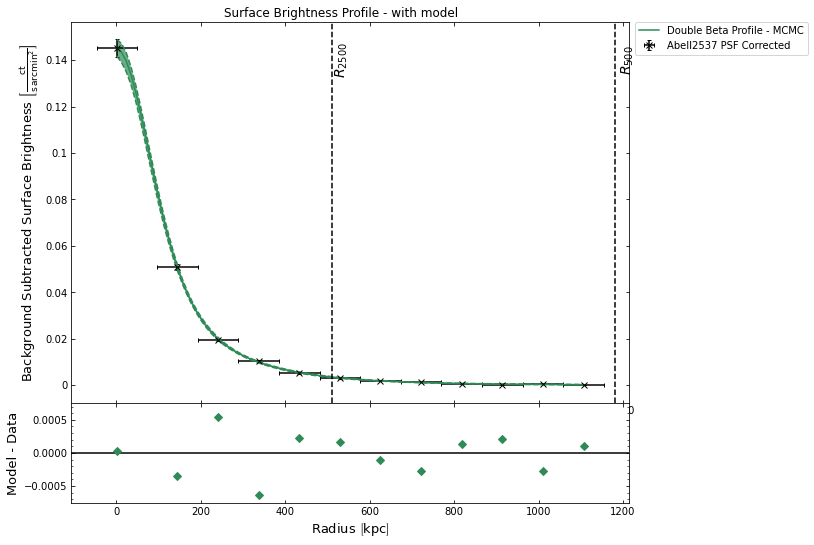

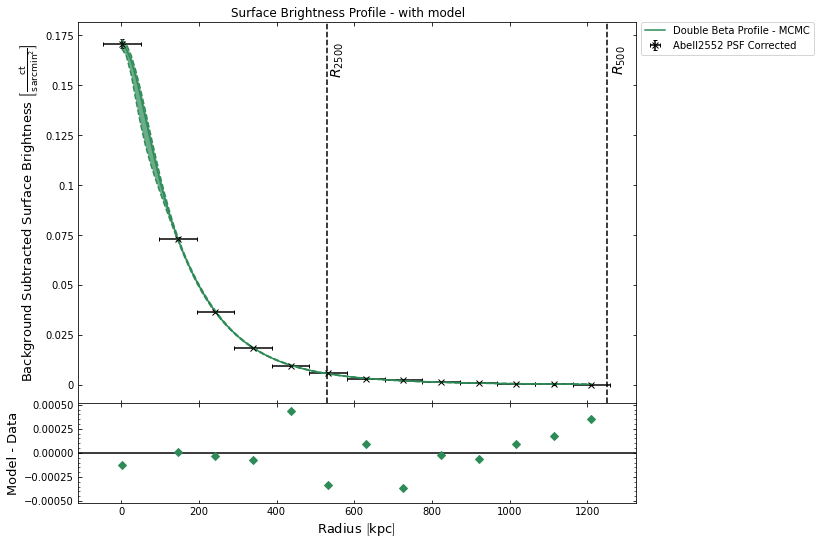

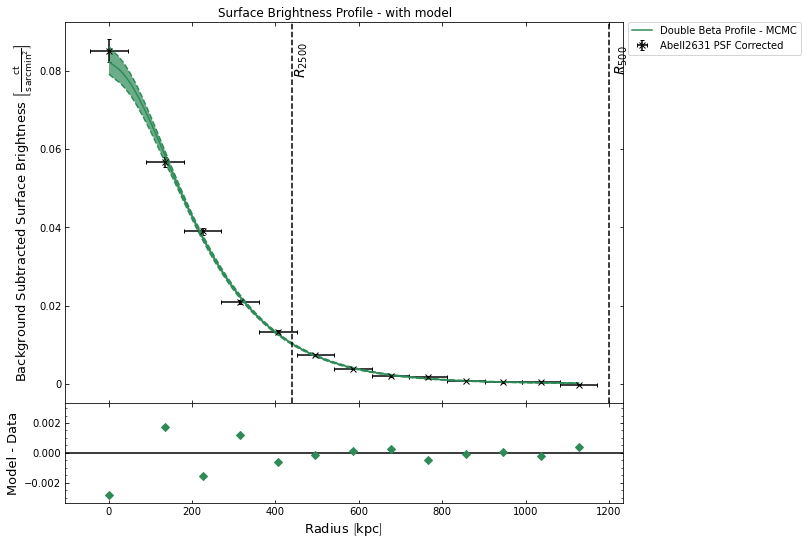

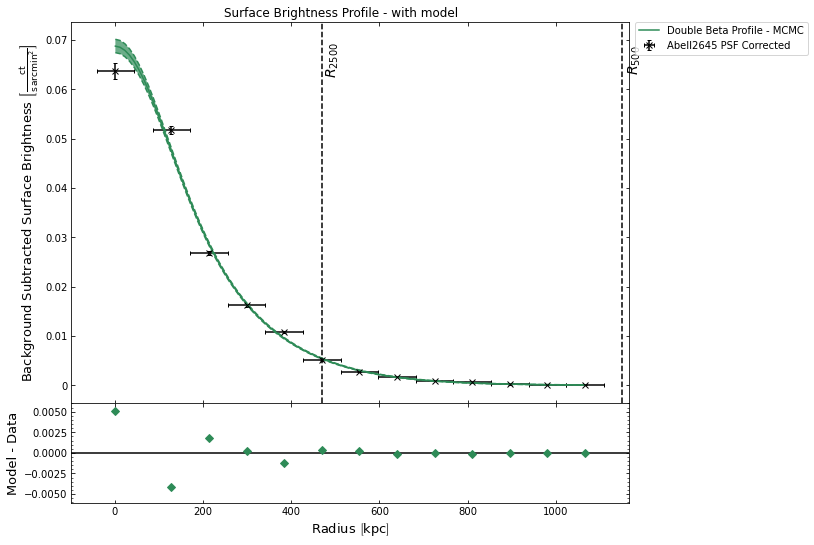

In [41]:
for dp in loc_dblbeta_1r500_5px_dp:
    try:
        dp.generation_profile.view(draw_rads={r'$R_{500}$': locuss_srcs[dp.src_name].r500, 
                                              r'$R_{2500}$': locuss_srcs[dp.src_name].r2500}, 
                                   xscale='linear', yscale='linear')
    except:
        pass